# Модель оттока и сегментации клиентов

**Описание проекта:**

**Заказчик проекта** - Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и продукты. Ключевая потребность заказчика — удерживать активность постоянных клиентов.

**Цель проекта** -  разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи проекта:**
- построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

**Источники данных:**

Файл market_file.csv содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
Файл market_money.csv содержит данные  о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
Файл market_time.csv — таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
Файл money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**План проекта:**

1. Загрузить и изучить данные.
2. Предобработать данные. Проверить на наличие пропусков и дубликатов.
3. Провести исследовательский анализ признаков. Отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 
4. Объединить таблицы.
5. Провести корреляционный анализ признаков. Устранить мультиколинеарность признаков. 
6. Использовать пайплайны. Обучить четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() с подбором гиперпараметров.Выбрать оптимальную метрику.Выбрать лучшую модель по отобранной метрике.
7. Провести анализ важности признаков. Оценить важность признаков для лучшей модели и построить график важности с помощью метода SHAP.
8. Провести сегментацию покупателей.   Выбрать группу покупателей и предложить, как увеличить её покупательскую активность: 
9. Общий вывод.

<div class="alert alert-success">
<h2> Комментарий ревьюера  <a class="tocSkip"> </h2>

👍 Отлично по описанию. Цели, задачи и план ясны.
</div>
 


## Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import sklearn

from scipy import stats as st
from math import factorial
from scipy.stats import binom

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures,
    LabelEncoder
)


from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    roc_curve,
    roc_auc_score,
    RocCurveDisplay,
    make_scorer
)

from yellowbrick.classifier.rocauc import roc_auc
from sklearn.model_selection import cross_val_score


import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix


from itertools import combinations
from scipy.spatial.distance import euclidean,cityblock

from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from optuna.integration import OptunaSearchCV
from optuna import distributions
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 


import time
from scipy.stats import pearsonr
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
try:
    df_market_file = pd.read_csv('market_file.csv', decimal=',')
except:
    df_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv', decimal=',')

In [4]:
df_market_file.sample(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
1224,216572,Прежний уровень,стандарт,нет,5.3,4,1013,0.26,Мелкая бытовая техника и электроника,4,0,1,4
861,216209,Прежний уровень,стандарт,нет,4.1,4,169,0.17,Товары для детей,5,0,3,6
1252,216600,Прежний уровень,премиум,да,4.4,4,349,0.4,Домашний текстиль,5,4,0,8
1092,216440,Прежний уровень,стандарт,да,3.2,4,703,0.3,Мелкая бытовая техника и электроника,2,1,6,6
76,215424,Снизилась,премиум,да,3.8,3,813,0.36,Домашний текстиль,3,3,2,2
698,216046,Прежний уровень,премиум,да,5.5,4,170,0.28,Домашний текстиль,4,5,3,11
1264,216612,Прежний уровень,стандарт,да,4.7,4,1013,0.14,Кухонная посуда,3,2,0,14
352,215700,Снизилась,премиум,да,3.1,4,681,0.27,Косметика и аксесуары,1,5,6,7
1074,216422,Прежний уровень,стандарт,да,5.2,5,726,0.25,Мелкая бытовая техника и электроника,4,5,6,12
160,215508,Снизилась,стандарт,да,3.5,5,574,0.22,Домашний текстиль,3,2,2,2


In [5]:
df_market_file.shape

(1300, 13)

Данные в таблице соответствуют описанию.

In [6]:
try:
    df_market_money = pd.read_csv('market_money.csv', decimal=',')
except:
    df_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', decimal=',')

In [7]:
df_market_money.sample(10)

,id,Период,Выручка
817,215620,текущий_месяц,5247.2
2920,216321,предыдущий_месяц,3233.0
2368,216137,текущий_месяц,6252.8
3171,216405,предыдущий_месяц,4637.0
3482,216508,текущий_месяц,5813.4
3476,216506,препредыдущий_месяц,4768.0
132,215392,препредыдущий_месяц,4341.0
868,215637,текущий_месяц,5010.9
2078,216040,текущий_месяц,4989.8
2467,216170,текущий_месяц,5086.8


In [8]:
df_market_money.shape

(3900, 3)

Данные в таблице соответствуют описанию.

In [9]:
try:
    df_market_time = pd.read_csv('market_time.csv', decimal=',')
except:
    df_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', decimal=',')

In [10]:
df_market_time.sample(10)

,id,Период,минут
1393,216044,текущий_месяц,13
1571,216133,текущий_месяц,12
456,215576,текущий_месяц,9
2316,216506,текущий_месяц,13
2504,216600,предыдцщий_месяц,17
2255,216475,предыдцщий_месяц,16
1266,215981,предыдцщий_месяц,14
2227,216461,предыдцщий_месяц,14
248,215472,текущий_месяц,8
290,215493,предыдцщий_месяц,9


In [11]:
df_market_time.shape

(2600, 3)

Данные в таблице соответствуют описанию.

In [12]:
try:
    df_money = pd.read_csv('money.csv', sep=';', decimal=',')
except:
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

In [13]:
df_money.sample(10)

,id,Прибыль
536,215884,4.37
804,216152,3.91
950,216298,5.07
650,215998,5.07
164,215512,4.41
682,216030,4.77
1262,216610,3.61
540,215888,3.85
359,215707,2.49
654,216002,4.28


In [14]:
df_money.shape

(1300, 2)

Данные в таблице соответствуют описанию.

In [15]:
df_market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [16]:
df_market_file=df_market_file.rename(
    columns={
        'Покупательская активность':'purchasing_activity',
        'Тип сервиса':'service_type', 
        'Разрешить сообщать': 'notification_permition', 
        'Маркет_актив_6_мес': 'marketing_activity_6_months', 
        'Маркет_актив_тек_мес': 'marketing_activity_current_month', 
        'Длительность': 'duration', 
        'Акционные_покупки': 'promotional_purchases', 
        'Популярная_категория': 'popular_category',
        'Средний_просмотр_категорий_за_визит': 'av_categories_amount_per_visit',
        'Неоплаченные_продукты_штук_квартал': 'unpaid_products_amount_quarter', 
        'Ошибка_сервиса': 'service_error', 
        'Страниц_за_визит': 'pages_per_visit'
    })
df_market_file

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
1296,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9
1297,216645,Прежний уровень,стандарт,да,4.1,3,586,0.2,Домашний текстиль,3,2,5,7
1298,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7


In [17]:
df_market_money.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [18]:
df_market_money=df_market_money.rename(
    columns={
        'Период': 'period', 
        'Выручка': 'revenue' 
    })    
df_market_money

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


In [19]:
df_market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [20]:
df_market_time=df_market_time.rename(
    columns={
        'Период': 'period',
        'минут': 'minutes'
    })
df_market_time

,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
...,...,...,...
2595,216645,текущий_месяц,18
2596,216646,предыдцщий_месяц,18
2597,216646,текущий_месяц,7
2598,216647,текущий_месяц,10


In [21]:
df_money.columns

Index(['id', 'Прибыль'], dtype='object')

In [22]:
df_money=df_money.rename(
    columns={
        'Прибыль': 'profit',
    })
df_money

,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21
...,...,...
1295,216643,4.44
1296,216644,6.11
1297,216645,3.29
1298,216646,4.03


### Итого по разделу:
- Датасеты загружены, признаки и их значения соответствуют описанию.
- Названия признаков приведены к стандарту.

## Предобработка данных


In [23]:
def check_df(df):
    """
    Проверяет pandas DataFrame на наличие пропущенных значений и дубликатов.
    
    Параметры:
    df (pandas.DataFrame): DataFrame для проверки.
    
    Выводит:
    - информацию о DataFrame,
    - количество и распределение пропущенных значений,
    - количество явных дубликатов,
    - первые пять строк DataFrame.
    """
    print("Общая инфо:")
    df.info()
    
    print("\nПроверка на наличие пропусков:")
    null_values = df.isnull().sum()
    if null_values.sum() > 0:
            print("В датафрейме есть пропущенные значения:")
            print(null_values)
    else:
        print("Пропущенные значения в датафрейме отсутствуют.")
    
    print("\nПроверка на наличие дубликатов:")
    duplicates = df.duplicated().sum()
    if duplicates > 0:
        print(f"В датафрейме найдено {duplicates} явных дубликатов.")
    else:
        print("Явные дубликаты в датафрейме отсутствуют.")
    
    display(df.head())

# Для получения документации функции использовать:
#help(check_df)

In [24]:
check_df(df_market_file)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   id                                1300 non-null   int64 
 1   purchasing_activity               1300 non-null   object
 2   service_type                      1300 non-null   object
 3   notification_permition            1300 non-null   object
 4   marketing_activity_6_months       1300 non-null   object
 5   marketing_activity_current_month  1300 non-null   int64 
 6   duration                          1300 non-null   int64 
 7   promotional_purchases             1300 non-null   object
 8   popular_category                  1300 non-null   object
 9   av_categories_amount_per_visit    1300 non-null   int64 
 10  unpaid_products_amount_quarter    1300 non-null   int64 
 11  service_error                     1300 non-null   int64 
 12  pages_pe

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Значения marketing_activity_6_months необходимо преобразовать из object во float

In [25]:
df_market_file.id.duplicated().sum()

0

Выборка представлена уникальными клиентами (1 запись = 1 клиент)

In [26]:
df_market_file['marketing_activity_6_months'] = pd.to_numeric(
    df_market_file['marketing_activity_6_months'], errors='coerce'
    )

In [27]:
df_market_file['promotional_purchases'] = pd.to_numeric(
    df_market_file['promotional_purchases'], errors='coerce'
    )

In [28]:
cat_col=['purchasing_activity', 'service_type', 'notification_permition', 'popular_category']

In [29]:
# Создадим функцию для поиска уникальных значений в категориальных столбцах
def unique_value(column_list, df):
    for i in column_list:
        print(f"Уникальные значения {i}: {df[i].unique()}")

In [30]:
unique_value(cat_col, df_market_file)

Уникальные значения purchasing_activity: ['Снизилась' 'Прежний уровень']
Уникальные значения service_type: ['премиум' 'стандартт' 'стандарт']
Уникальные значения notification_permition: ['да' 'нет']
Уникальные значения popular_category: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Выявили неявные дубли в признаке "service_type", исправим это

In [31]:
df_market_file['service_type'] = df_market_file['service_type'].str.replace(
    'стандартт', 'стандарт', regex=True
    )
df_market_file['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [32]:
check_df(df_market_file)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1300 non-null   int64  
 1   purchasing_activity               1300 non-null   object 
 2   service_type                      1300 non-null   object 
 3   notification_permition            1300 non-null   object 
 4   marketing_activity_6_months       1300 non-null   float64
 5   marketing_activity_current_month  1300 non-null   int64  
 6   duration                          1300 non-null   int64  
 7   promotional_purchases             1300 non-null   float64
 8   popular_category                  1300 non-null   object 
 9   av_categories_amount_per_visit    1300 non-null   int64  
 10  unpaid_products_amount_quarter    1300 non-null   int64  
 11  service_error                     1300 non-null   int64  

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [33]:
check_df(df_market_money)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   period   3900 non-null   object
 2   revenue  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Значения revenue необходимо преобразовать из object во float

In [34]:
df_market_money['revenue'] = pd.to_numeric(
    df_market_money['revenue'], errors='coerce'
    )

In [35]:
# Проверим кат. признак на неявные дубли
print(f"Уникальные значения period: {df_market_money['period'].unique()}")

Уникальные значения period: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [36]:
check_df(df_market_money)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Неявные дубли остутствуют, данные имеют корректный формат.

In [37]:
check_df(df_market_time)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [38]:
# Проверим кат. признак на неявные дубли
print(f"Уникальные значения period: {df_market_time['period'].unique()}")

Уникальные значения period: ['текущий_месяц' 'предыдцщий_месяц']


Неявные дубли в period отстутствуют, но значения с опечаткой. Исправим во избежание ошибок в будущем.

In [39]:
df_market_time['period'] = df_market_time['period'].str.replace(
    'предыдцщий_месяц', 'предыдущий_месяц', regex=True
    )
df_market_time['period'].unique()


array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [40]:
check_df(df_money)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


### Итого по разделу:
 - найдены и удалены неявные дубликаты.
 - типы данных приведены в соответствие.

## Исследовательский анализ данных

  ### Статистический анализ признаков df_market_file, визуализация

In [41]:
# Создадим функцию для визуализации диаграмм размаха.
def plot_boxplot(data, column_name):
    plt.figure(figsize=(14, 3))  # Задаем размер фигуры
    sns.boxplot(data=data, x=column_name, showmeans=True)  # Строим диаграмму расмаха с указанием среднего значения
    plt.title(f'Диаграмма размаха для признака "{column_name}"')  # Заголовок графика
    plt.xlabel(column_name)  # Подпись оси X
    plt.show() 

In [42]:
# Создадим функцию для интерпретации стат данных.
def interpret_boxplot(data, column_name):
    """
    Расчитывает и выводит стат показатели
    Параметры:
    df (df, название столбца): .
    
    Выводит:
    - Значений выходящих за доверительные интервалы,
    - 25% значений до Q1
    - 50% значений до Q1-Q3,
    - 25% значений превышают Q3
    - Медиана
    - Среднее
    """
    # Вычисляем квартили и межквартильный размах
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    median = data[column_name].median()
    mean = data[column_name].mean()
    
    # Определяем границы усов (выбросы могут находиться за этими границами)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Проверяем наличие выбросов
    outliers_exist = ((data[column_name] < lower_bound) | (data[column_name] > upper_bound)).any()
    outliers_message = "есть" if outliers_exist else "нет"
    
    # Выводим результаты
    print(f"Статистический анализ признака:")
    print(f"1. Значений выходящих за доверительные интервалы {outliers_message}.")
    print(f"2. 25% значений '{column_name}' - до {Q1}.")
    print(f"3. 50% значений '{column_name}' в диапазоне от {Q1} до {Q3}.")
    print(f"4. 25% значений '{column_name}' превышают {Q3}.")
    print(f"5. Медиана {round(median, 2)}")
    print(f"6. Среднее {round(mean, 2)}")

In [43]:
help(interpret_boxplot)

Help on function interpret_boxplot in module __main__:

interpret_boxplot(data, column_name)
    Расчитывает и выводит стат показатели
    Параметры:
    df (df, название столбца): .
    
    Выводит:
    - Значений выходящих за доверительные интервалы,
    - 25% значений до Q1
    - 50% значений до Q1-Q3,
    - 25% значений превышают Q3
    - Медиана
    - Среднее



In [44]:
df_market_file.sample(5)

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit
1202,216550,Прежний уровень,премиум,да,4.4,5,744,0.16,Мелкая бытовая техника и электроника,3,2,4,8
802,216150,Прежний уровень,стандарт,да,4.3,4,283,0.11,Кухонная посуда,3,4,5,14
863,216211,Прежний уровень,премиум,да,6.3,3,1030,0.13,Домашний текстиль,4,2,5,9
200,215548,Снизилась,стандарт,да,3.5,4,903,0.35,Кухонная посуда,3,1,3,4
280,215628,Снизилась,стандарт,да,4.0,4,618,0.93,Товары для детей,3,5,2,2


#### Анализ категориальных признаков df_market_file

In [45]:
df_market_file.pivot_table(index='purchasing_activity', values='id', aggfunc='count')

,id
purchasing_activity,
Прежний уровень,802
Снизилась,498


In [46]:
df_market_file.pivot_table(index='service_type', values='id', aggfunc='count')

,id
service_type,
премиум,376
стандарт,924


In [47]:
df_market_file.pivot_table(index='notification_permition', values='id', aggfunc='count')

,id
notification_permition,
да,962
нет,338


In [48]:
df_market_file.pivot_table(index='popular_category', values='id', aggfunc='count')

,id
popular_category,
Домашний текстиль,251
Косметика и аксесуары,223
Кухонная посуда,138
Мелкая бытовая техника и электроника,174
Техника для красоты и здоровья,184
Товары для детей,330


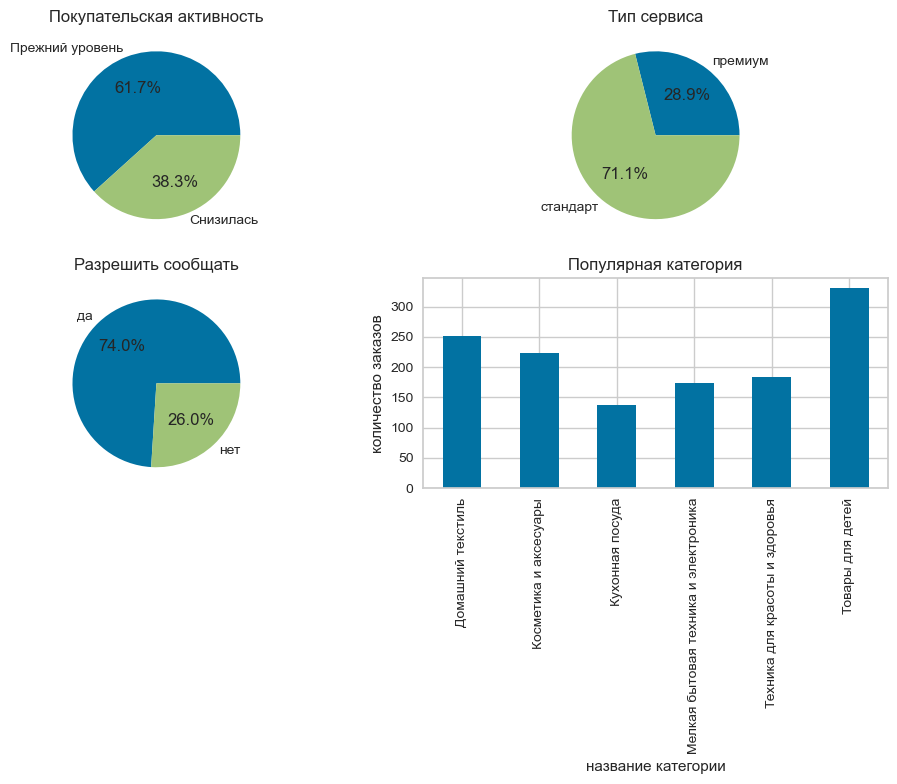

In [49]:
# Создаем фигуру и оси для 4 подграфиков
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# График "Покупательская активность"
df_market_file.pivot_table(index='purchasing_activity', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[0, 0])
ax[0, 0].set_title('Покупательская активность')
ax[0, 0].set_ylabel('')
ax[0, 0].set_xlabel('')

# График "Тип сервиса"
df_market_file.pivot_table(index='service_type', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[0, 1])
ax[0, 1].set_title('Тип сервиса')
ax[0, 1].set_ylabel('')
ax[0, 1].set_xlabel('')

# График "Разрешить сообщать"
df_market_file.pivot_table(index='notification_permition', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[1, 0])
ax[1, 0].set_title('Разрешить сообщать')
ax[1, 0].set_ylabel('')
ax[1, 0].set_xlabel('')

# График "Популярная категория"
df_market_file.pivot_table(index='popular_category', values='id', aggfunc='count').plot(kind='bar', grid=True, legend=False, ax=ax[1, 1])
ax[1, 1].set_title('Популярная категория')
ax[1, 1].set_ylabel('количество заказов')
ax[1, 1].set_xlabel('название категории')

# Для лучшей организации пространства между подграфиками
plt.tight_layout()

# Показываем фигуру
plt.show()


In [50]:
df_market_file.pivot_table(
    index='marketing_activity_current_month',
    values='id', 
    aggfunc='count')


,id
marketing_activity_current_month,
3,308
4,669
5,323


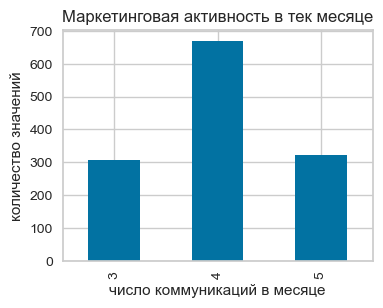

In [51]:
(df_market_file.pivot_table(
    index='marketing_activity_current_month',
    values='id', 
    aggfunc='count'
).plot(kind='bar', grid=True, figsize=(4, 3), legend=False))
plt.title('Маркетинговая активность в тек месяце')
plt.ylabel('количество значений')
plt.xlabel('число коммуникаций в месяце')
plt.show()

**Итого по категориальным признакам:**

**Итого по целевому признаку "Покупательская активность"**: 
В выборке представлено 2 типа активности, с долями распределения  61,7%, (802 наблюдения) - Прежний уровень, 38,3% (498 наблюдений) - Снизилась. Наблюдаем незначительный дисбаланс классов  для целевого признака.

**Итого по категориальному признаку "Тип сервиса"**: 
В выборке представлено 2 типа сервиса, с долями распределения  71,1%, (924 наблюдения) - стандарт, 28,9% (376 наблюдений) - премиум.

**Итого по категориальному признаку "Разрешить сообщать":**
В выборке представлено 2 типа наблюдений, с долями распределения 74,0 (962 наблюдения) - да, 26,0% (338 наблюдений) - нет.

**Итого по категориальному признаку "Популярная категория":**
В выборке представлено 6 категорий товаров, с значительным преобладанием категории "Товары для детей". Кухонная посуда - наименее встречающаяся категория (138 заказов).

**Итого по категориальному признаку "Маркет_актив_тек_мес":**
В выборке представлено 3 значения активности. Наиболее частое значение (699 наблюдений) - 4 коммуникации с клиентом в тек месяце. Количество значений в 3 и 5 коммуникаций практически совпадают (308 и 323 соответственно)

#### Анализ количественнных признаков df_market_file

In [52]:
df_market_file['marketing_activity_6_months'].describe()

count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: marketing_activity_6_months, dtype: float64

In [53]:
interpret_boxplot(df_market_file, 'marketing_activity_6_months')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'marketing_activity_6_months' - до 3.7.
3. 50% значений 'marketing_activity_6_months' в диапазоне от 3.7 до 4.9.
4. 25% значений 'marketing_activity_6_months' превышают 4.9.
5. Медиана 4.2
6. Среднее 4.25


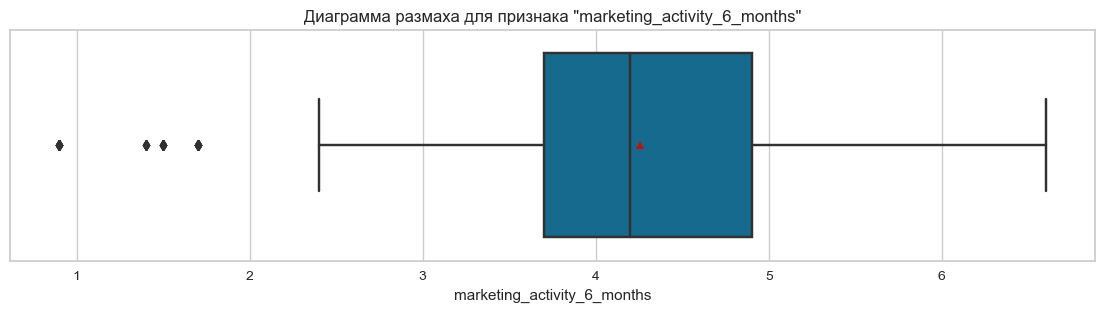

In [54]:
plot_boxplot(df_market_file, 'marketing_activity_6_months')

Наблюдаем несколько выбивающихся значений, находящихся за пределами левого доверительного интервала. При этом нет оснований из удалять т.к. эти значения не явлются чем-то уникальным.

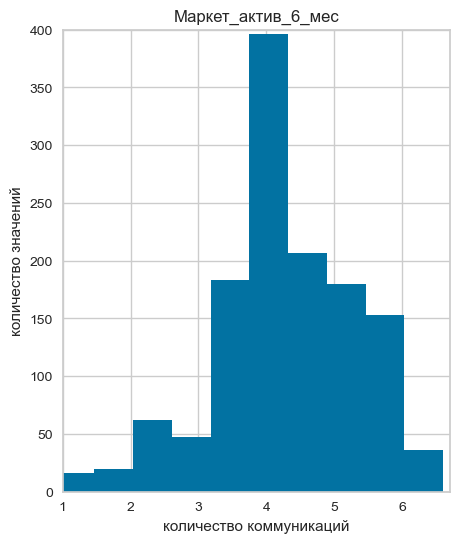

In [55]:
df_market_file.plot(y='marketing_activity_6_months', kind='hist', grid=True, figsize=(5, 6),
bins=10, ylim=(0, 400), xlim=(1, 6.7), 
legend=False)
plt.title('Маркет_актив_6_мес')
plt.ylabel('количество значений')
plt.xlabel('количество коммуникаций')
plt.show()

Пик распределения (мода, или наибольшее количество наблюдений) приходится на 4 коммуникации за рассматриваемый период. Распределение стремится к нормальному с удлиненным левым хвостом.

In [56]:
df_market_file['duration'].describe()

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64

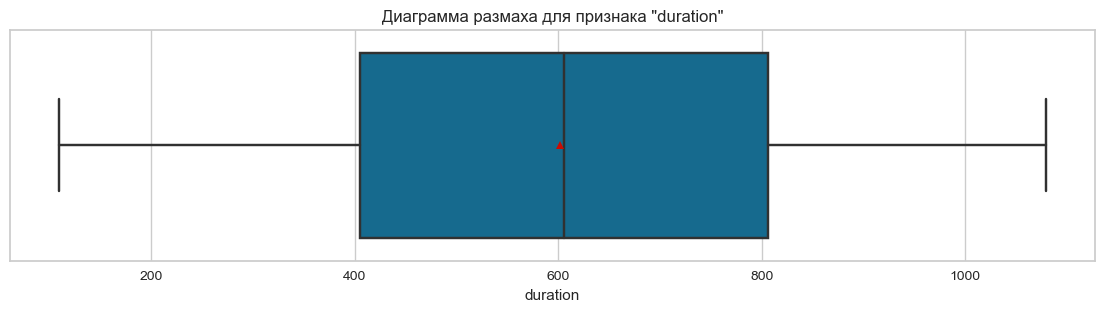

In [57]:
plot_boxplot(df_market_file, 'duration')

In [58]:
interpret_boxplot(df_market_file, 'duration')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'duration' - до 405.5.
3. 50% значений 'duration' в диапазоне от 405.5 до 806.0.
4. 25% значений 'duration' превышают 806.0.
5. Медиана 606.0
6. Среднее 601.9


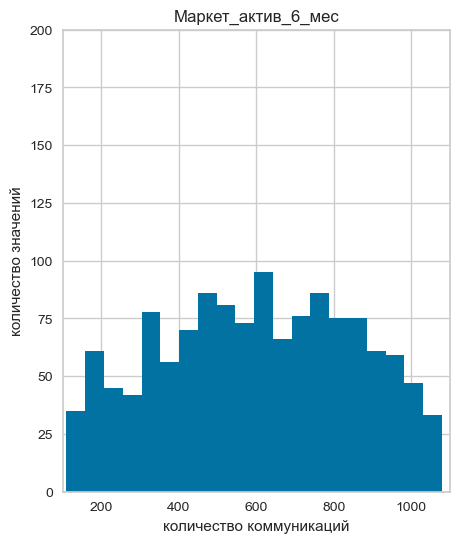

In [59]:
df_market_file.plot(y='duration', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 200), xlim=(100, 1100), 
legend=False)
plt.title('Маркет_актив_6_мес')
plt.ylabel('количество значений')
plt.xlabel('количество коммуникаций')
plt.show()

Распределение стремится к нормальному с невыраженной модов в диапазоне 600-650 дней. Вероятно также существуют объективные огранения, которые препятствуют получению менеее 110 дней (вероятно исскуственное ограничение на минимальную глубину данных при их выгрузке) и 1100 (вероятно это максимальная глубина данных). 

In [60]:
df_market_file['promotional_purchases'].describe()

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promotional_purchases, dtype: float64

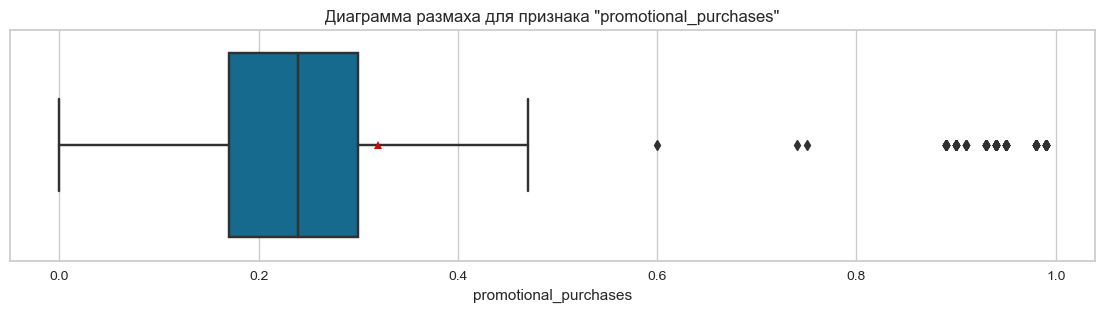

In [61]:
plot_boxplot(df_market_file, 'promotional_purchases')

In [62]:
interpret_boxplot(df_market_file, 'promotional_purchases')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'promotional_purchases' - до 0.17.
3. 50% значений 'promotional_purchases' в диапазоне от 0.17 до 0.3.
4. 25% значений 'promotional_purchases' превышают 0.3.
5. Медиана 0.24
6. Среднее 0.32


Наблюдаем выбивающиеся значения, находящихся за пределами правого доверительного интервала. При этом нет оснований их удалять т.к. эти значения не являются ошибкой (не превышают 1).

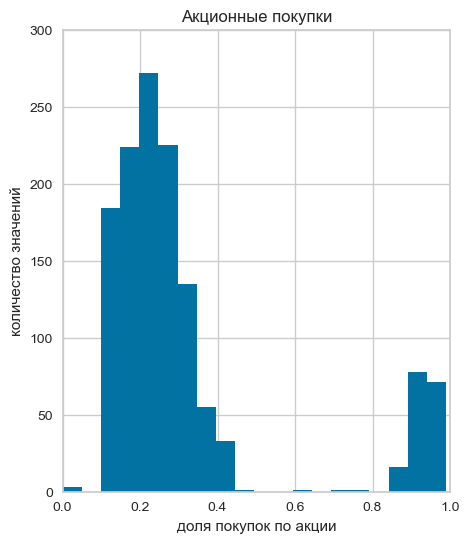

In [63]:
df_market_file.plot(y='promotional_purchases', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 300), xlim=(0, 1), 
legend=False)
plt.title('Акционные покупки')
plt.ylabel('количество значений')
plt.xlabel('доля покупок по акции')
plt.show()

Распределение бимодальное (имеет 2 пика), с модами в дипапазоне 0,2-0,25 и 0,9-0,95. Распределение несимметрично, имеется перекос влево, с большей частотой значений, сосредоточенных в начале диапазона. Значения в правой части диапазона - нетипичные, возможно это связано с ошибками в реализации промо, либо наличием клиентов, для которых промо является единственным триггером к покупке (искатели скидок, истощающие маркетиновые бюджеты).

In [64]:
df_market_file['av_categories_amount_per_visit'].describe()

count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: av_categories_amount_per_visit, dtype: float64

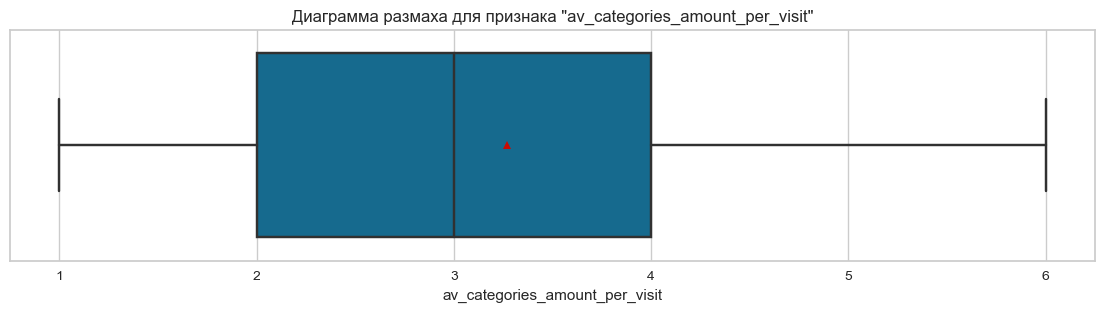

In [65]:
plot_boxplot(df_market_file, 'av_categories_amount_per_visit')

In [66]:
interpret_boxplot(df_market_file, 'av_categories_amount_per_visit')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'av_categories_amount_per_visit' - до 2.0.
3. 50% значений 'av_categories_amount_per_visit' в диапазоне от 2.0 до 4.0.
4. 25% значений 'av_categories_amount_per_visit' превышают 4.0.
5. Медиана 3.0
6. Среднее 3.27


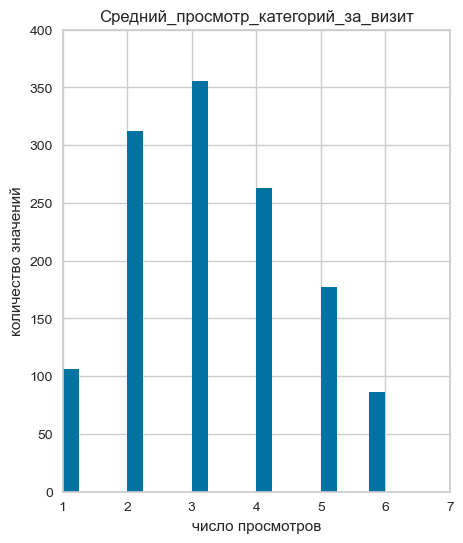

In [67]:
df_market_file.plot(y='av_categories_amount_per_visit', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 400), xlim=(1, 7), 
legend=False)
plt.title('Средний_просмотр_категорий_за_визит')
plt.ylabel('количество значений')
plt.xlabel('число просмотров')
plt.show()

Распределение стремится к нормальному с модой 3 и незначительным смещением влево.

In [68]:
df_market_file['unpaid_products_amount_quarter'].describe()

count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_products_amount_quarter, dtype: float64

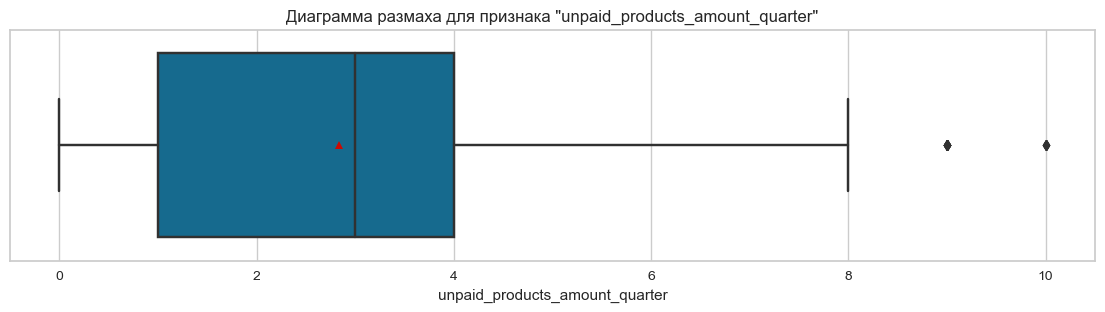

In [69]:
plot_boxplot(df_market_file, 'unpaid_products_amount_quarter')

In [70]:
interpret_boxplot(df_market_file, 'unpaid_products_amount_quarter')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'unpaid_products_amount_quarter' - до 1.0.
3. 50% значений 'unpaid_products_amount_quarter' в диапазоне от 1.0 до 4.0.
4. 25% значений 'unpaid_products_amount_quarter' превышают 4.0.
5. Медиана 3.0
6. Среднее 2.84


Наблюдаем 2 выбивающихся значения, находящихся за пределами правого доверительного интервала. При этом нет оснований их удалять т.к. эти значения не являются чем-то невозможным (не превышают 1).

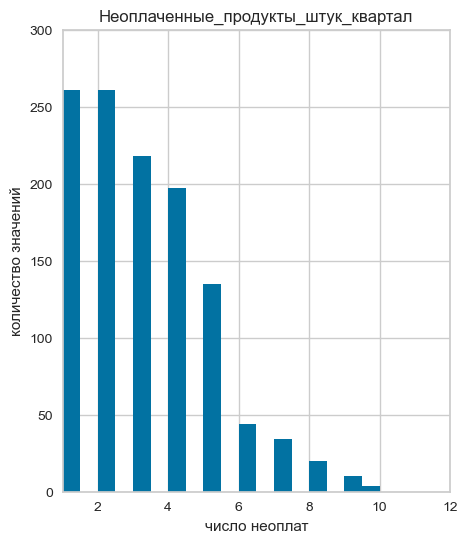

In [71]:
df_market_file.plot(y='unpaid_products_amount_quarter', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 300), xlim=(1, 12), 
legend=False)
plt.title('Неоплаченные_продукты_штук_квартал')
plt.ylabel('количество значений')
plt.xlabel('число неоплат')
plt.show()

Наблюдаем левостороннее ассиметричное распределение, что логично для данного признака.

In [72]:
df_market_file['service_error'].describe()

count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: service_error, dtype: float64

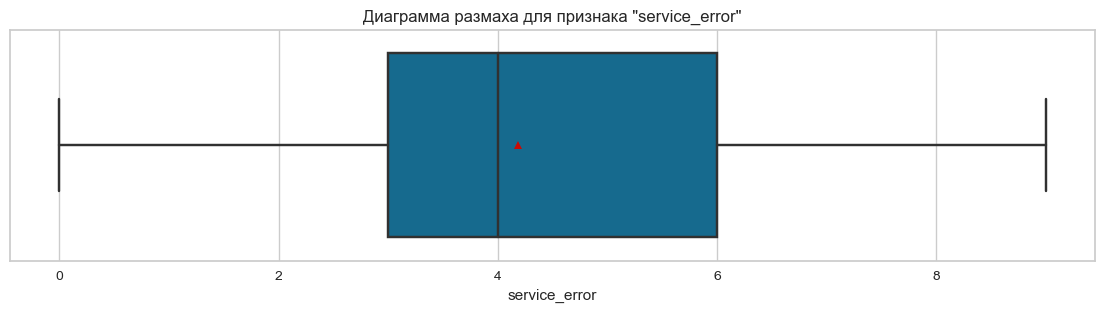

In [73]:
plot_boxplot(df_market_file, 'service_error')

In [74]:
interpret_boxplot(df_market_file, 'service_error')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'service_error' - до 3.0.
3. 50% значений 'service_error' в диапазоне от 3.0 до 6.0.
4. 25% значений 'service_error' превышают 6.0.
5. Медиана 4.0
6. Среднее 4.19


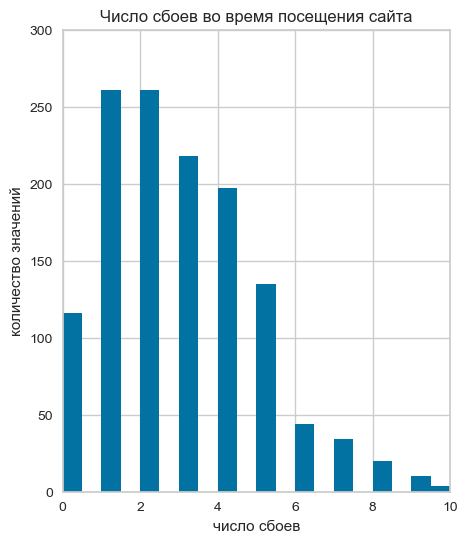

In [75]:
df_market_file.plot(y='unpaid_products_amount_quarter', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 300), xlim=(0, 10), 
legend=False)
plt.title('Число сбоев во время посещения сайта')
plt.ylabel('количество значений')
plt.xlabel('число сбоев')
plt.show()

Наблюдаем левостороннее ассиметричное распределение. Однако, лишь чуть более 100 из 1300 клиентов в данной выборке не сталкивались с проблемами при взаимодействии с сайтом (менее 10%). Это может указывать на серьезные проблемы в работе этой он-лайн площадки.  

In [76]:
df_market_file['pages_per_visit'].describe()

count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit, dtype: float64

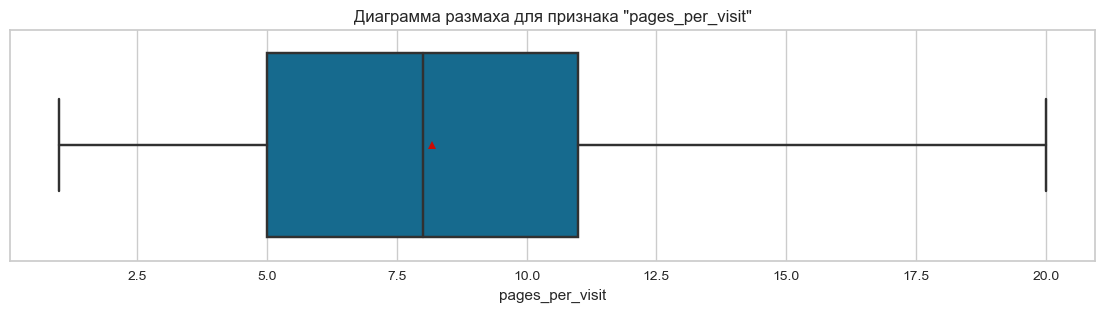

In [77]:
plot_boxplot(df_market_file, 'pages_per_visit')

In [78]:
interpret_boxplot(df_market_file, 'pages_per_visit')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'pages_per_visit' - до 5.0.
3. 50% значений 'pages_per_visit' в диапазоне от 5.0 до 11.0.
4. 25% значений 'pages_per_visit' превышают 11.0.
5. Медиана 8.0
6. Среднее 8.18


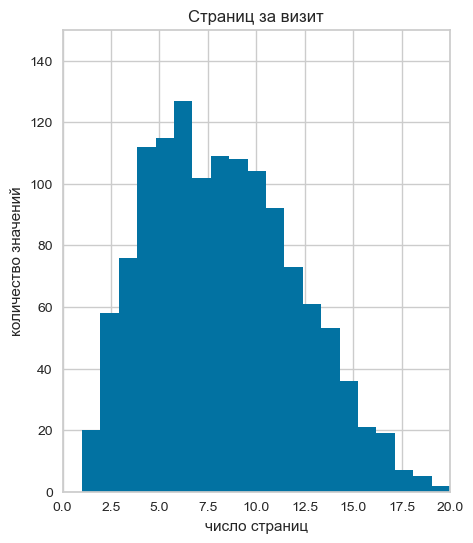

In [79]:
df_market_file.plot(y='pages_per_visit', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 150), xlim=(0, 20), 
legend=False)
plt.title('Страниц за визит')
plt.ylabel('количество значений')
plt.xlabel('число страниц')
plt.show()

Распределение стремится к нормальному распределению, с незначительным смещением пика влево. Пик распределения в диапазоне 5-7,5 страниц, что может указывать на наличие заинтересованности большей части аудитории в контенте площадки. 

**Итого по количественным признакам  market_file:**

**Маркет_актив_тек_мес** 
- 25% значений 'marketing_activity_6_months' - до 3.7.
- 50% значений 'marketing_activity_6_months' в диапазоне от 3.7 до 4.9.
- 25% значений 'marketing_activity_6_months' превышают 4.9.
- Наблюдаем несколько выбивающихся значений, находящихся за пределами левого доверительного интервала. Пик распределения (мода, или наибольшее количество наблюдений) приходится на 4 коммуникации за рассматриваемый период. Распределение стремится к нормальному с удлиненным левым хвостом.

**Маркет_актив_тек_мес**
- 25% значений 'marketing_activity_6_months' - до 3.7.
- 50% значений 'marketing_activity_6_months' в диапазоне от 3.7 до 4.9.
- 25% значений 'marketing_activity_6_months' превышают 4.9.
- Наблюдаем несколько выбивающихся значений, находящихся за пределами левого доверительного интервала. Пик распределения (мода, или наибольшее количество наблюдений) приходится на 4 коммуникации за рассматриваемый период. Распределение стремится к нормальному с удлиненным левым хвостом.

**Длительность**
- Значений выходящих за доверительные интервалы нет.
- 25% значений 'duration' - до 405.5.
- 50% значений 'duration' в диапазоне от 405.5 до 806 дней.
- 25% значений 'duration' превышают 806.0. 
- Распределение стремится к нормальному с невыраженной модов в диапазоне 600-650 дней. Вероятно также существуют объективные огранения, которые препятствуют получению менеее 110 дней (вероятно исскуственное ограничение на минимальную глубину данных при их выгрузке) и 1100 (вероятно это максимальная глубина данных).

**Акционные_покупки:**
- Наблюдаем выбивающиеся значения, находящихся за пределами правого доверительного интервала. 
- 25% значений 'promotional_purchases' - до 0.17.
- 50% значений 'promotional_purchases' в диапазоне от 0.17 до 0.3.
- 25% значений 'promotional_purchases' превышают 0.3.
- Распределение бимодальное (имеет 2 пика), с модами в дипапазоне 0,2-0,25 и 0,9-0,95. Распределение несимметрично, имеется перекос влево, с большей частотой значений, сосредоточенных в начале диапазона. Значения в правой части диапазона - нетипичные, возможно это связано с ошибками в реализации промо, либо наличием клиентов, для которых промо является единственным триггером к покупке (искатели скидок, истощающие маркетиновые бюджеты).

**Средний_просмотр_категорий_за_визит:**
- Значений выходящих за доверительные интервалы нет.
- 25% значений 'av_categories_amount_per_visit' - до 2.0.
- 50% значений 'av_categories_amount_per_visit' в диапазоне от 2.0 до 4.0.
- 25% значений 'av_categories_amount_per_visit' превышают 4.0.
- Распределение стремится к нормальному с модой 3 и незначительным смещением влево.

**Неоплаченные_продукты_штук_квартал:**
- Наблюдаем 2 выбивающихся значения, находящихся за пределами правого доверительного интервала. 
- 25% значений 'unpaid_products_amount_quarter' - до 1.0.
- 50% значений 'unpaid_products_amount_quarter' в диапазоне от 1.0 до 4.0.
- 25% значений 'unpaid_products_amount_quarter' превышают 4.0
- Наблюдаем левостороннее ассиметричное распределение, что логично для данного признака.

**Ошибка_сервиса:**
- Значений выходящих за доверительные интервалы нет.
- 25% значений 'service_error' - до 3.0.
- 50% значений 'service_error' в диапазоне от 3.0 до 6.0.
- 25% значений 'service_error' превышают 6.0.
- Наблюдаем левостороннее ассиметричное распределение. Однако, лишь чуть более 100 из 1300 клиентов в данной выборке не сталкивались с проблемами при взаимодействии с сайтом (менее 10%). Это может указывать на серьезные проблемы в работе этой он-лайн площадки. 

**Страниц_за_визит:**
- Значений выходящих за доверительные интервалы нет.
- 25% значений 'pages_per_visit' - до 5.0.
- 50% значений 'pages_per_visit' в диапазоне от 5.0 до 11.0.
- 25% значений 'pages_per_visit' превышают 11.0.
- Распределение стремится к нормальному распределению, с незначительным смещением пика влево. Пик распределения в диапазоне 5-7,5 страниц, что может указывать на наличие заинтересованности большей части аудитории в контенте площадки.

#### Проведем доп анализ в разрезе целевого признака.

In [80]:
# Разделим выборку по целевому признаку.
df_market_file_active_users = df_market_file.query('purchasing_activity=="Прежний уровень"')
df_market_file_active_users.sample(2)

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit
664,216012,Прежний уровень,премиум,да,4.9,3,576,0.44,Кухонная посуда,3,0,2,9
1051,216399,Прежний уровень,стандарт,да,3.8,4,265,0.95,Техника для красоты и здоровья,5,2,1,12


In [81]:
df_market_file_churn_users =df_market_file.query('purchasing_activity=="Снизилась"')
df_market_file_churn_users.sample(2)

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit
140,215488,Снизилась,стандарт,да,4.1,4,748,0.93,Кухонная посуда,3,4,2,4
23,215371,Снизилась,стандарт,да,3.8,4,365,0.21,Домашний текстиль,5,0,6,1


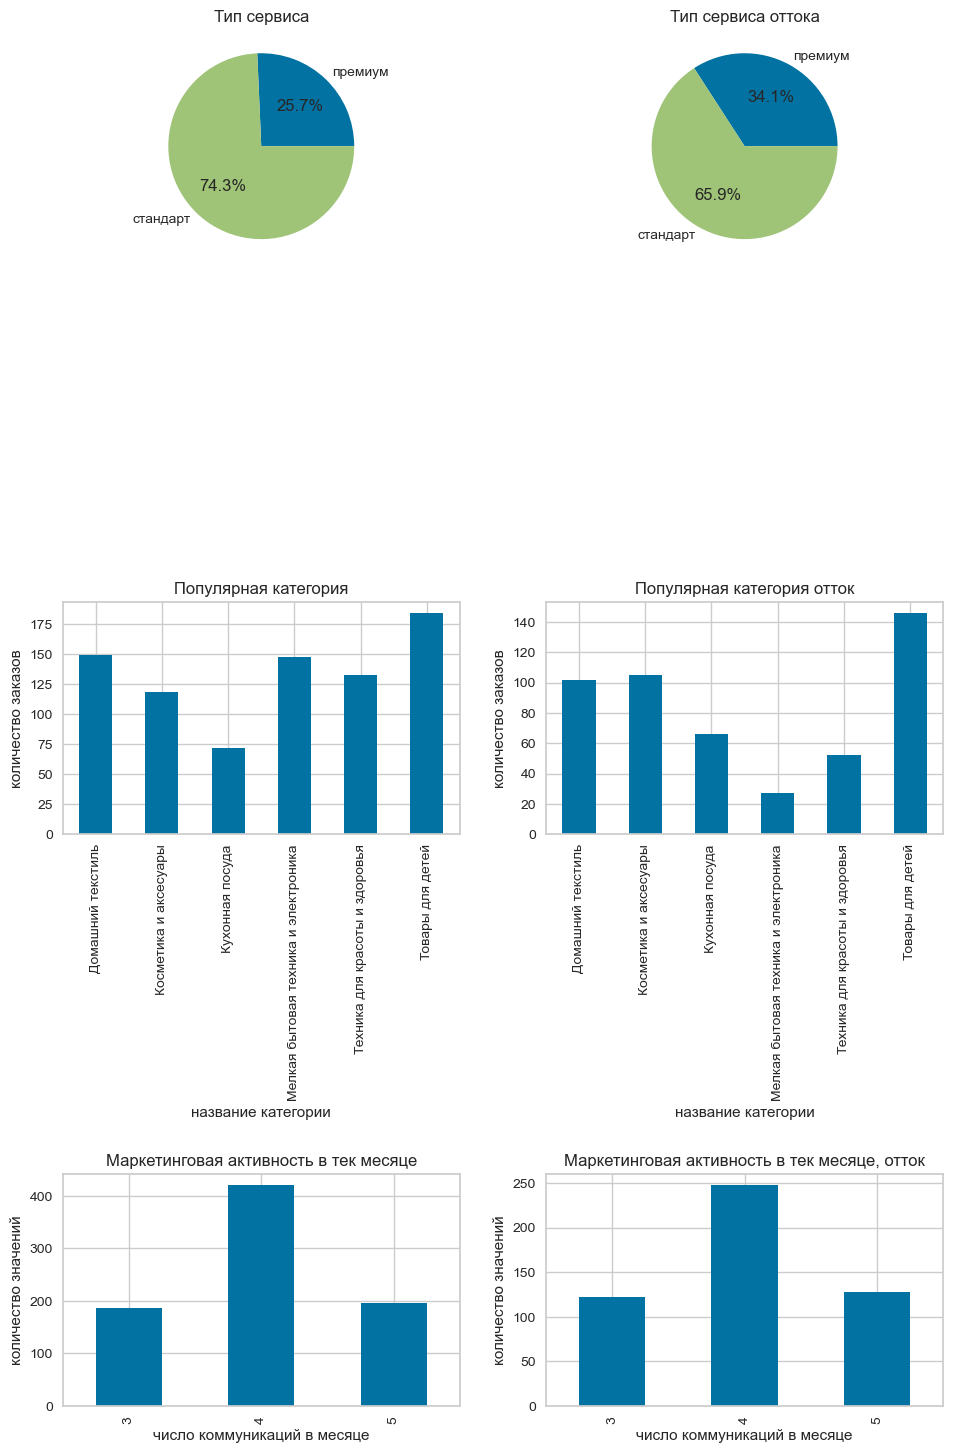

In [82]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# График "Тип сервиса"
df_market_file_active_users.pivot_table(index='service_type', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[0, 0])
ax[0, 0].set_title('Тип сервиса')
ax[0, 0].set_ylabel('')
ax[0, 0].set_xlabel('')

# График "Тип сервиса"
df_market_file_churn_users.pivot_table(index='service_type', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[0, 1])
ax[0, 1].set_title('Тип сервиса оттока')
ax[0, 1].set_ylabel('')
ax[0, 1].set_xlabel('')

# График "Популярная категория"
df_market_file_active_users.pivot_table(index='popular_category', values='id', aggfunc='count').plot(kind='bar', grid=True, legend=False, ax=ax[1, 0])
ax[1, 0].set_title('Популярная категория')
ax[1, 0].set_ylabel('количество заказов')
ax[1, 0].set_xlabel('название категории')

# График "Популярная категория"
df_market_file_churn_users.pivot_table(index='popular_category', values='id', aggfunc='count').plot(kind='bar', grid=True, legend=False, ax=ax[1, 1])
ax[1, 1].set_title('Популярная категория отток')
ax[1, 1].set_ylabel('количество заказов')
ax[1, 1].set_xlabel('название категории')

(df_market_file_active_users.pivot_table(
    index='marketing_activity_current_month',
    values='id', 
    aggfunc='count'
).plot(kind='bar', grid=True, legend=False, ax=ax[2, 0]))
ax[2, 0].set_title('Маркетинговая активность в тек месяце')
ax[2, 0].set_ylabel('количество значений')
ax[2, 0].set_xlabel('число коммуникаций в месяце')

(df_market_file_churn_users.pivot_table(
    index='marketing_activity_current_month',
    values='id', 
    aggfunc='count'
).plot(kind='bar', grid=True, legend=False, ax=ax[2, 1]))
ax[2, 1].set_title('Маркетинговая активность в тек месяце, отток')
ax[2, 1].set_ylabel('количество значений')
ax[2, 1].set_xlabel('число коммуникаций в месяце')

plt.tight_layout(pad=2.0) 
plt.show()


1. В признаке популярная категория" пользователи склонные к оттоку гораздо меньше интересуются категориями "мелкая быловая техника и электроника" и "техника для красоты и здоровья"
2. Среди пользователей склонных к оттоку доля сервиса "премиум" выше (34,1 против 25,7)

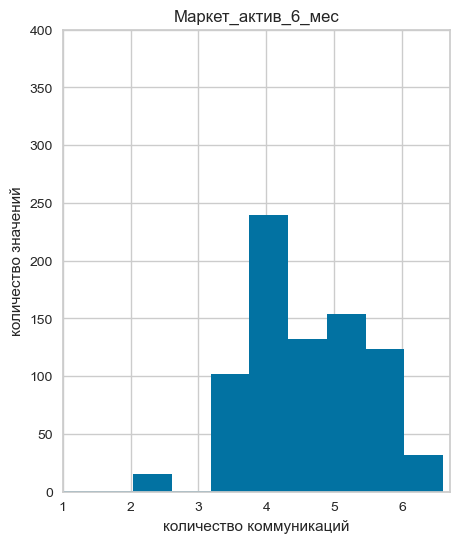

In [83]:
df_market_file_active_users.plot(y='marketing_activity_6_months', kind='hist', grid=True, figsize=(5, 6),
bins=10, ylim=(0, 400), xlim=(1, 6.7), 
legend=False)
plt.title('Маркет_актив_6_мес')
plt.ylabel('количество значений')
plt.xlabel('количество коммуникаций')
plt.show()

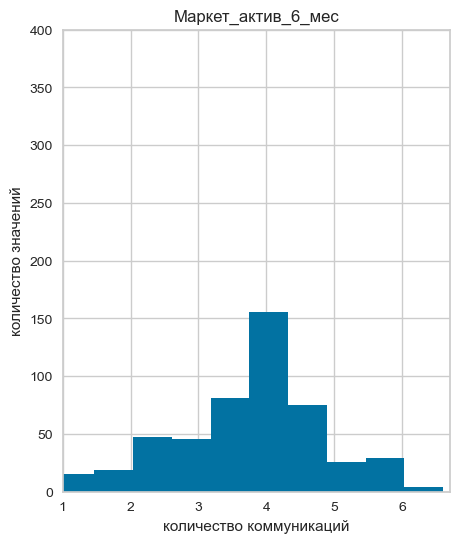

In [84]:
df_market_file_churn_users.plot(y='marketing_activity_6_months', kind='hist', grid=True, figsize=(5, 6),
bins=10, ylim=(0, 400), xlim=(1, 6.7), 
legend=False)
plt.title('Маркет_актив_6_мес')
plt.ylabel('количество значений')
plt.xlabel('количество коммуникаций')
plt.show()

Маркет_актив_6_мес:

Несмотря на то, что мода осталась без изменений, значительная часть наблюдений активных пользователей в правой части распределения (получают больше коммуникаций), в то время как для пользователей склонных к оттоку распределение более симметричное.

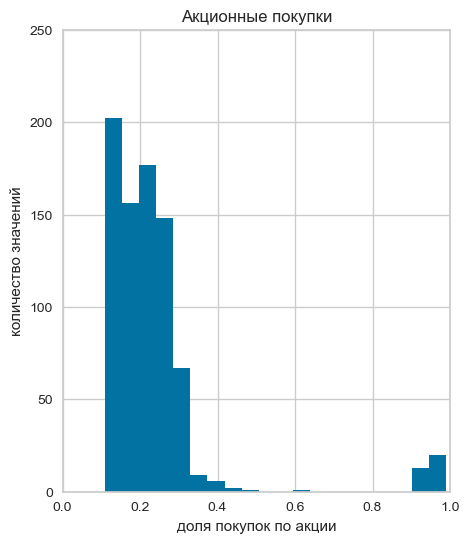

In [85]:
df_market_file_active_users.plot(y='promotional_purchases', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 250), xlim=(0, 1), 
legend=False)
plt.title('Акционные покупки')
plt.ylabel('количество значений')
plt.xlabel('доля покупок по акции')
plt.show()

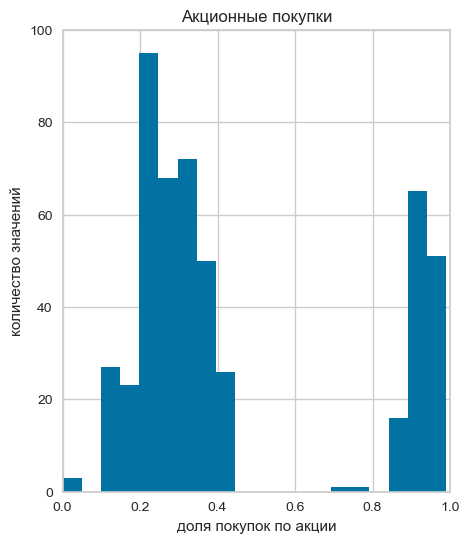

In [86]:
df_market_file_churn_users.plot(y='promotional_purchases', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 100), xlim=(0, 1), 
legend=False)
plt.title('Акционные покупки')
plt.ylabel('количество значений')
plt.xlabel('доля покупок по акции')
plt.show()

Акционные покупки:

Оба распределения бимодальны,  с модами в дипапазоне 0,2-0,25 и 0,9-0,95. Однако, для пользователей склонных к оттоку второй пик гораздо более выраженный (доля "акционщиков" значительно больше чем для "активных" пользователей. 

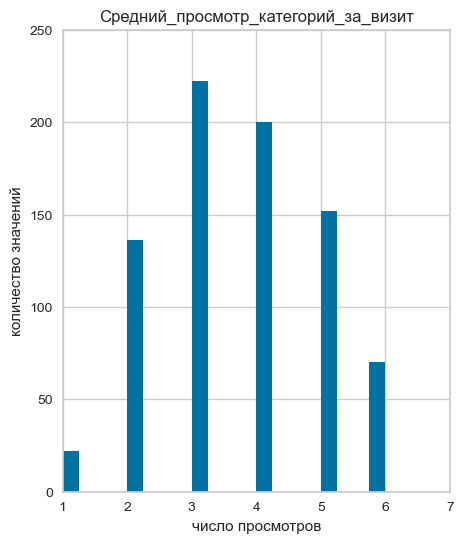

In [87]:
df_market_file_active_users.plot(y='av_categories_amount_per_visit', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 250), xlim=(1, 7), 
legend=False)
plt.title('Средний_просмотр_категорий_за_визит')
plt.ylabel('количество значений')
plt.xlabel('число просмотров')
plt.show()

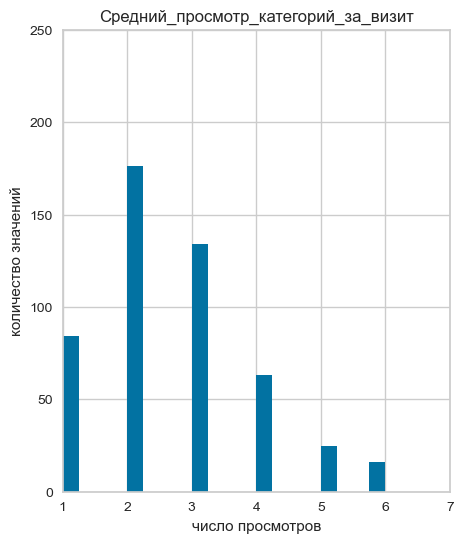

In [88]:
df_market_file_churn_users.plot(y='av_categories_amount_per_visit', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 250), xlim=(1, 7), 
legend=False)
plt.title('Средний_просмотр_категорий_за_визит')
plt.ylabel('количество значений')
plt.xlabel('число просмотров')
plt.show()

In [89]:
df_market_file_active_users['av_categories_amount_per_visit'].describe()

count    802.000000
mean       3.665835
std        1.277112
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: av_categories_amount_per_visit, dtype: float64

In [90]:
df_market_file_churn_users['av_categories_amount_per_visit'].describe()

count    498.000000
mean       2.632530
std        1.229871
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        6.000000
Name: av_categories_amount_per_visit, dtype: float64

Средний просмотр категорий за визит:
Мода пользователей склонных к оттоку - 2 категории,  у активных пользователей - 3.  Медиана 2 и 4 соответственно. Пользователи склонные к оттоку просматривают значительно меньше интересуются другими товарами.   

### Статистический анализ признаков df_market_money, визуализация¶

In [91]:
df_market_money.sample(10)

,id,period,revenue
1474,215839,предыдущий_месяц,4987.0
2462,216168,предыдущий_месяц,5551.0
242,215428,текущий_месяц,5444.0
2786,216276,предыдущий_месяц,4773.0
2833,216292,препредыдущий_месяц,5039.0
1986,216010,препредыдущий_месяц,5028.0
1935,215993,препредыдущий_месяц,4743.0
1201,215748,предыдущий_месяц,5083.0
632,215558,препредыдущий_месяц,4968.0
1744,215929,препредыдущий_месяц,4983.0


In [92]:
# Найдем пользователей, которые ничего не покупали хотя бы в 1м из 3 анализируемых месяцев.
not_active_users=df_market_money.query('revenue == 0')
not_active_users

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Наблюдаем 6 записей (3х пользователей с покупательской активностью менее 3 месяцев). Удалим записи этих пользователей, согласно условию проекта.

In [93]:
id_not_active_users=not_active_users.id.unique()
id_not_active_users

array([215348, 215357, 215359], dtype=int64)

In [94]:
df_market_money = df_market_money[~df_market_money['id'].isin(id_not_active_users)]

In [95]:
df_market_money.pivot_table(index='period', values='id', aggfunc='count')

,id
period,
предыдущий_месяц,1297
препредыдущий_месяц,1297
текущий_месяц,1297


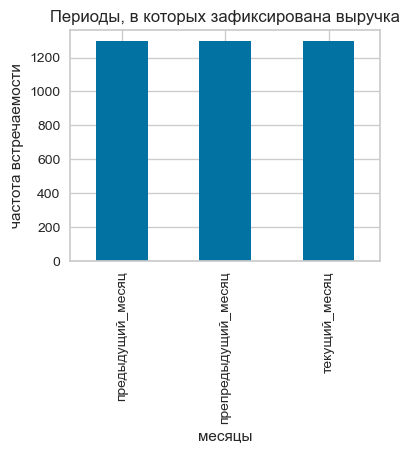

In [96]:
(df_market_money.pivot_table(index='period', values='id', aggfunc='count').plot(kind='bar', grid=True, figsize=(4, 3), legend=False))
plt.title('Периоды, в которых зафиксирована выручка')
plt.ylabel('частота встречаемости')
plt.xlabel('месяцы')
plt.show()

Записи с доходом равномерно распределены по месяцам (по 1300 наблюдений на каждый месяц), что указывает на то, что выборка не менялась за 3 анализируемых месяца (те же самые пользователи, исключен отток и новые пользователи)

In [97]:
df_market_money['revenue'].describe()

count      3891.000000
mean       5033.718890
std        1768.471286
min        2758.700000
25%        4592.000000
50%        4959.000000
75%        5363.200000
max      106862.200000
Name: revenue, dtype: float64

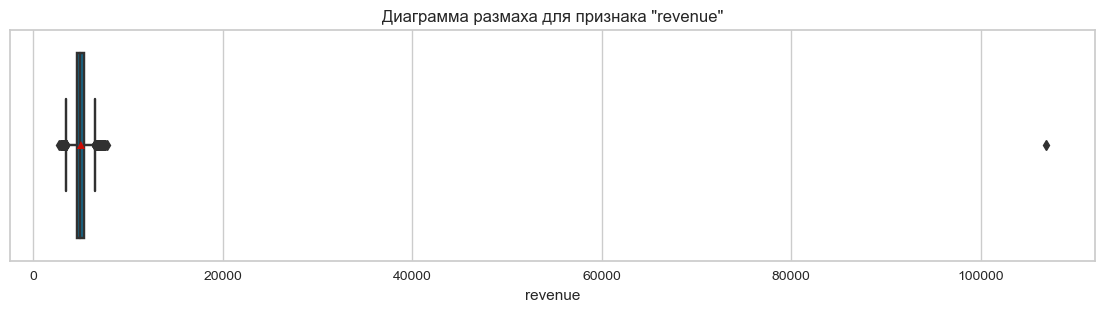

In [98]:
plot_boxplot(df_market_money, 'revenue')

In [99]:
interpret_boxplot(df_market_money, 'revenue')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'revenue' - до 4592.0.
3. 50% значений 'revenue' в диапазоне от 4592.0 до 5363.2.
4. 25% значений 'revenue' превышают 5363.2.
5. Медиана 4959.0
6. Среднее 5033.72


In [100]:
#посмотрим на выбивающиеся наблюдения
df_market_money.query('revenue > 200000 |revenue < 1000')

,id,period,revenue


In [101]:
# Находим id пользователя с выбиващимся revenue > 100000
user_id_to_correct = df_market_money.query('revenue > 100000')['id'].iloc[0]

In [102]:
# Вычисляем среднее значение revenue для этого пользователя
average_revenue = df_market_money.query('id == @user_id_to_correct')['revenue'].mean()

In [103]:
# Заменяем значение revenue на среднее
df_market_money.loc[(df_market_money['id'] == user_id_to_correct) & (df_market_money['revenue'] > 100000), 'revenue'] = average_revenue

In [104]:
#проверяем
df_market_money.query('revenue > 100000 |revenue < 1000')

,id,period,revenue


In [105]:
df_market_money.pivot_table(index='period', values='id', aggfunc='count')

,id
period,
предыдущий_месяц,1297
препредыдущий_месяц,1297
текущий_месяц,1297


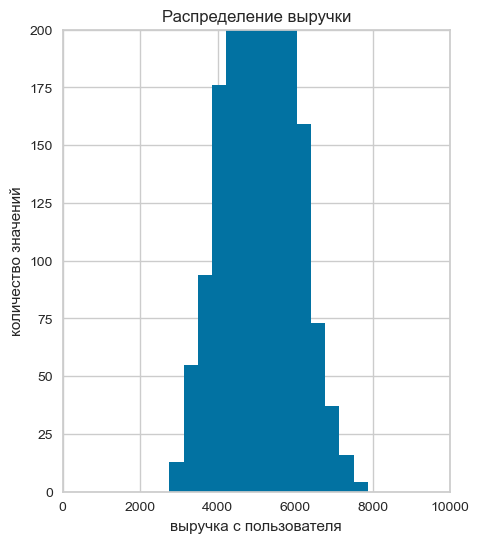

In [106]:
df_market_money.plot(y='revenue', kind='hist', grid=True, figsize=(5, 6),
bins=100, ylim=(0, 200), xlim=(0, 10000), 
legend=False)
plt.title('Распределение выручки')
plt.ylabel('количество значений')
plt.xlabel('выручка с пользователя')
plt.show()

Распределение имеет вид нормального распределения с низкой дисперсией, этим в т.ч. объясняется, почему значения выбились за доверительные интервалы. 

**Итого по итогам анализа признаков df_market_money:**

**Качественный признак Период:**
- Записи с доходом равномерно распределены по месяцам (по 1300 наблюдений на каждый месяц), что указывает на то, что выборка не менялась за 3 анализируемых месяца (те же самые пользователи, исключен отток и новые пользователи)

**Количественный признак Выручка:
 - 25% значений 'revenue' - до 4590.15.
 - 50% значений 'revenue' в диапазоне от 4590.15 до 5363.0.
 - 25% значений 'revenue' превышают 5363.0.
 - Распределение имеет вид нормального распределения с низкой дисперсией, этим в т.ч. объясняется, почему значения выбились за доверительные интервалы. Удален выброс.

**Отобраны клиенты с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.**


### Статистический анализ признаков df_market_time, визуализация¶

In [107]:
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


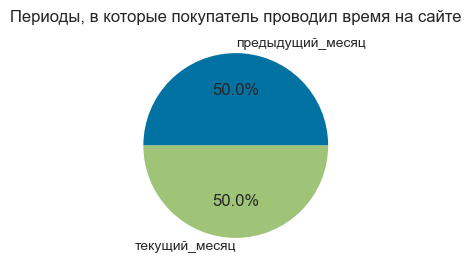

In [108]:
(df_market_time.pivot_table(index='period', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True,
figsize=(4, 3), legend=False, autopct='%1.1f%%'))
plt.title('Периоды, в которые покупатель проводил время на сайте')
plt.ylabel('')
plt.xlabel('')
plt.show()

Записи с выручкой равномерно распределены по месяцам (по 1300 наблюдений на текущий и предыдущий месяцы), что указывает на то, что выборка не менялась (те же самые пользователи, исключен отток и новые пользователи)

In [109]:
df_market_time['minutes'].describe()

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64

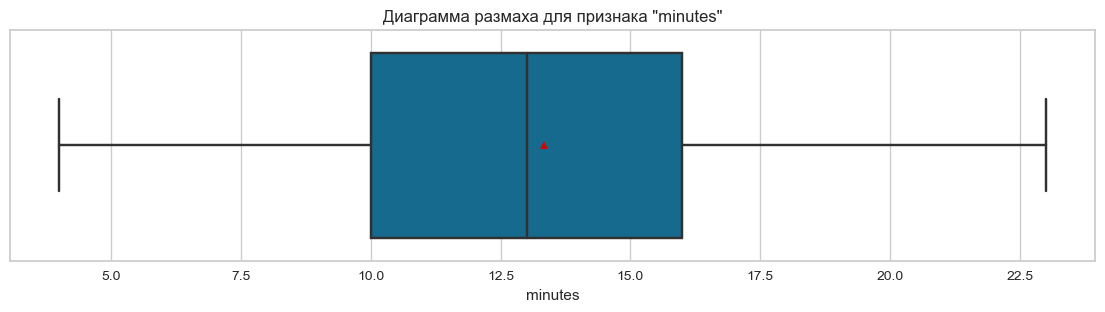

In [110]:
plot_boxplot(df_market_time, 'minutes')

In [111]:
interpret_boxplot(df_market_time, 'minutes')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы нет.
2. 25% значений 'minutes' - до 10.0.
3. 50% значений 'minutes' в диапазоне от 10.0 до 16.0.
4. 25% значений 'minutes' превышают 16.0.
5. Медиана 13.0
6. Среднее 13.34


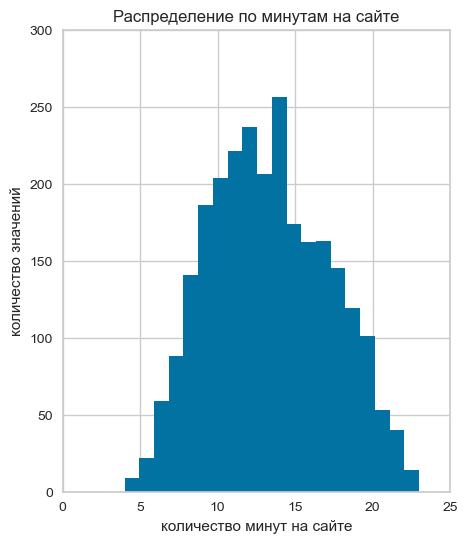

In [112]:
df_market_time.plot(y='minutes', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 300), xlim=(0, 25), 
legend=False)
plt.title('Распределение по минутам на сайте')
plt.ylabel('количество значений')
plt.xlabel('количество минут на сайте')
plt.show()

Распределение имеет форму нормального распределения с пиком в диапазоне 14-15 мин, что вероятно указывает на заинтересованность пользователей в контенте площадки.

**Итого по итогам анализа признаков df_market_time:**

**Качественный признак Период:**
- Записи с выручкой равномерно распределены по месяцам (по 1300 наблюдений на текущий и предыдущий месяцы), что указывает на то, что выборка не менялась (те же самые пользователи, исключен отток и новые пользователи)

**Количественный признак Выручка:
- Значений выходящих за доверительные интервалы нет.
- 25% значений 'minutes' - до 10.0.
- 50% значений 'minutes' в диапазоне от 10.0 до 16.0.
- 25% значений 'minutes' превышают 16.0.
- Распределение имеет форму нормального распределения с пиком в диапазоне 14-15 мин, что вероятно указывает на заинтересованность пользователей в контенте площадки.

### Статистический анализ признаков df_money, визуализация

In [113]:
df_money['profit'].describe()

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

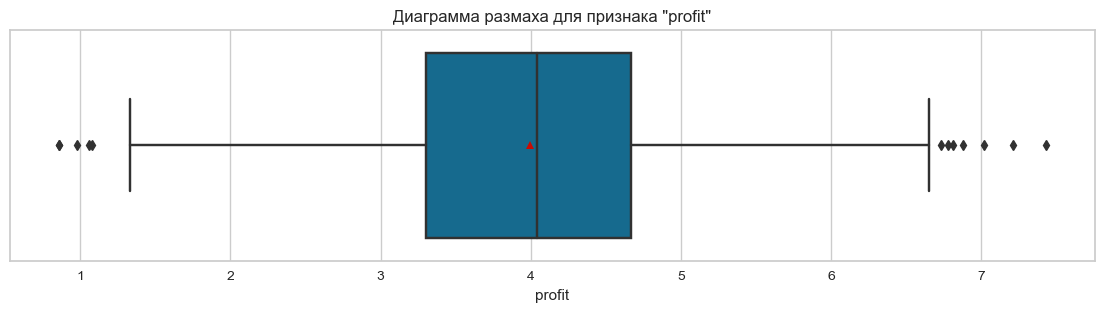

In [114]:
plot_boxplot(df_money, 'profit')

In [115]:
interpret_boxplot(df_money, 'profit')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'profit' - до 3.3.
3. 50% значений 'profit' в диапазоне от 3.3 до 4.67.
4. 25% значений 'profit' превышают 4.67.
5. Медиана 4.04
6. Среднее 4.0


Наблюдаем значения признака выбивающиеся за левый и правый интервалы

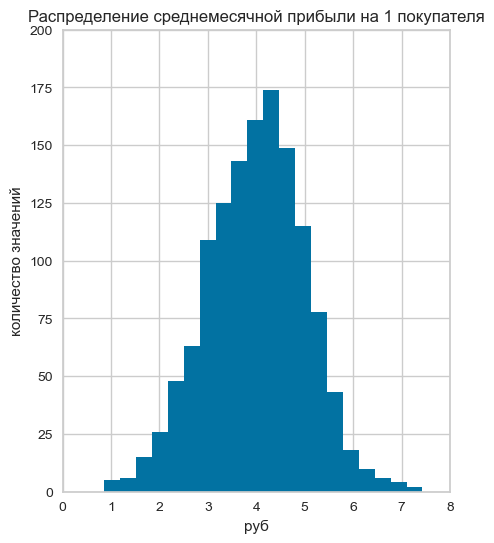

In [116]:
df_money.plot(y='profit', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 200), xlim=(0, 8), 
legend=False)
plt.title('Распределение среднемесячной прибыли на 1 покупателя')
plt.ylabel('количество значений')
plt.xlabel('руб')
plt.show()

Распределение имеет вид нормального распределения с низкой дисперсией, этим в т.ч. объясняется, почему значения выбились за доверительные интервалы. Т.к выбивающиеся значения не являются невозможными событиями не удаляем их.

### Итого по разделу:

1. **Исследовательский анализ признаков df_market_file:**

1.1. **Категориальные признаки**

**"Покупательская активность"**: 
В выборке представлено 2 типа активности, с долями распределения  61,7%, (802 наблюдения) - Прежний уровень, 38,3% (498 наблюдений) - Снизилась.

**"Тип сервиса"**: 
В выборке представлено 2 типа сервиса, с долями распределения  71,1%, (924 наблюдения) - стандарт, 28,9% (376 наблюдений) - премиум.

**"Разрешить сообщать":**
В выборке представлено 2 типа наблюдений, с долями распределения 74,0 (962 наблюдения) - да, 26,0% (338 наблюдений) - нет.

**"Популярная категория":**
В выборке представлено 6 категорий товаров, с значительным преобладанием категории "Товары для детей". Кухонная посуда - наименее встречающаяся категория (138 заказов).

**"Маркет_актив_тек_мес":**
В выборке представлено 3 значения активности. Наиболее частое значение (699 наблюдений) - 4 коммуникации с клиентом в тек месяце. Количество значений в 3 и 5 коммуникаций практически совпадают (308 и 323 соответственно)

1.2. **Количественные признаки df_market_file:

**Маркет_актив_тек_мес** 
- Наблюдаем несколько выбивающихся значений, находящихся за пределами левого доверительного интервала. Пик распределения (мода, или наибольшее количество наблюдений) приходится на 4 коммуникации за рассматриваемый период. Распределение стремится к нормальному с удлиненным левым хвостом.

**Маркет_актив_тек_мес**
- Наблюдаем несколько выбивающихся значений, находящихся за пределами левого доверительного интервала. Пик распределения (мода, или наибольшее количество наблюдений) приходится на 4 коммуникации за рассматриваемый период. Распределение стремится к нормальному с удлиненным левым хвостом.

**Длительность**
- Значений выходящих за доверительные интервалы нет.
- Распределение стремится к нормальному с невыраженной модов в диапазоне 600-650 дней. Вероятно также существуют объективные огранения, которые препятствуют получению менеее 110 дней (вероятно исскуственное ограничение на минимальную глубину данных при их выгрузке) и 1100 (вероятно это максимальная глубина данных).

**Акционные_покупки:**
- Наблюдаем выбивающиеся значения, находящихся за пределами правого доверительного интервала. 
- Распределение бимодальное (имеет 2 пика), с модами в дипапазоне 0,2-0,25 и 0,9-0,95. Распределение несимметрично, имеется перекос влево, с большей частотой значений, сосредоточенных в начале диапазона. Значения в правой части диапазона - нетипичные, возможно это связано с ошибками в реализации промо, либо наличием клиентов, для которых промо является единственным триггером к покупке (искатели скидок, истощающие маркетиновые бюджеты).

**Средний_просмотр_категорий_за_визит:**
- Значений выходящих за доверительные интервалы нет.
- Распределение стремится к нормальному с модой 3 и незначительным смещением влево.

**Неоплаченные_продукты_штук_квартал:**
- Наблюдаем 2 выбивающихся значения, находящихся за пределами правого доверительного интервала. 
- Наблюдаем левостороннее ассиметричное распределение, что логично для данного признака.

**Ошибка_сервиса:**
- Значений выходящих за доверительные интервалы нет.
- Наблюдаем левостороннее ассиметричное распределение. Однако, лишь чуть более 100 из 1300 клиентов в данной выборке не сталкивались с проблемами при взаимодействии с сайтом (менее 10%). Это может указывать на серьезные проблемы в работе этой он-лайн площадки. 

**Страниц_за_визит:**
- Значений выходящих за доверительные интервалы нет.
- Распределение стремится к нормальному распределению, с незначительным смещением пика влево. Пик распределения в диапазоне 5-7,5 страниц, что может указывать на наличие заинтересованности большей части аудитории в контенте площадки.

2. **Исследовательский анализ категориальных признаков df_market_file:**

**Категориальный признак Период:**
Записи с доходом равномерно распределены по месяцам (по 1300 наблюдений на каждый месяц), что указывает на то, что выборка не менялась за 3 анализируемых месяца (те же самые пользователи, исключен отток и новые пользователи)

**Количественный признак Выручка:**
- 25% значений 'revenue' - до 4590.15.
- 50% значений 'revenue' в диапазоне от 4590.15 до 5363.0.
- 25% значений 'revenue' превышают 5363.0.
- Распределение имеет вид нормального распределения с низкой дисперсией, этим в т.ч. объясняется, почему значения выбились за доверительные интервалы. Т.к выбивающиеся значения не являются невозможными событиями, не удаляем их.

3. **Анализ признаков df_market_time:**

**Категориальный признак Период:**
Записи с выручкой равномерно распределены по месяцам (по 1300 наблюдений на текущий и предыдущий месяцы), что указывает на то, что выборка не менялась (те же самые пользователи, исключен отток и новые пользователи)

**Количественный признак Выручка:**
- Значений выходящих за доверительные интервалы нет.
- 25% значений 'minutes' - до 10.0.
- 50% значений 'minutes' в диапазоне от 10.0 до 16.0.
- 25% значений 'minutes' превышают 16.0.
- Распределение имеет форму нормального распределения с пиком в диапазоне 14-15 мин, что вероятно указывает на заинтересованность пользователей в контенте площадки.

4.  **Количественный признак df_money Прибыль**,
- Есть значения выходящие за левый и правый доверительные интервалы 
- 25% значений 'profit' - до 3.3.
- 50% значений 'profit' в диапазоне от 3.3 до 4.67.
- 25% значений 'profit' превышают 4.67.
- Распределение имеет вид нормального распределения с низкой дисперсией, этим в т.ч. объясняется, почему значения выбились за доверительные интервалы. Т.к выбивающиеся значения не являются невозможными событиями (выручка 0 и выручка 107 тыс руб с пользователя), не удаляем их.

5. Доп анализ пользователей в разрезе целевого признака:
- В признаке популярная категория" пользователи склонные к оттоку гораздо меньше интересуются категориями "мелкая быловая техника и электроника" и "техника для красоты и здоровья"
- Среди пользователей склонных к оттоку доля сервиса "премиум" выше (34,1 против 25,7)
- Акционные покупки: оба распределения бимодальны,  с модами в дипапазоне 0,2-0,25 и 0,9-0,95. Однако, для пользователей склонных к оттоку второй пик гораздо более выраженный (доля "акционщиков" значительно больше чем для "активных" пользователей. 
- Маркет_актив_6_мес: Несмотря на то, что мода осталась без изменений, значительная часть наблюдений активных пользователей в правой части распределения (получают больше коммуникаций), в то время как для пользователей склонных к оттоку распределение более симметричное.
- Средний просмотр категорий за визит:
Мода пользователей склонных к оттоку - 2 категории,  у активных пользователей - 3.  Медиана 2 и 4 соответственно. Пользователи склонные к оттоку просматривают значительно меньше интересуются другими товарами.  

## Объединение таблиц

### Преобразование таблицы df_market_money

In [117]:
df_market_money.sample(5)

,id,period,revenue
314,215452,препредыдущий_месяц,4963.0
2830,216291,предыдущий_месяц,5333.5
2048,216030,препредыдущий_месяц,5298.0
2460,216168,текущий_месяц,4949.1
831,215625,препредыдущий_месяц,4777.0


In [118]:
df_market_money.shape

(3891, 3)

In [119]:
#Развернем таблицу так, чтобы  уникальные значения стоблца период стали стоблцами
df_market_money_transp = df_market_money.pivot_table(index='id', columns='period', values='revenue')
df_market_money_transp

period,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [120]:
df_market_money_transp.columns = [f'revenue_{col}' for col in df_market_money_transp.columns]
df_market_money_transp

,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


In [121]:
df_market_money_transp.reset_index(inplace=True)

In [122]:
df_market_money_transp

,id,revenue_предыдущий_месяц,revenue_препредыдущий_месяц,revenue_текущий_месяц
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [123]:
df_market_money_transp = df_market_money_transp.rename(
    columns={
        'revenue_предыдущий_месяц' : 'current_1_month_revenue',
        'revenue_препредыдущий_месяц':'current_2_month_revenue',
        'revenue_текущий_месяц':'current_month_revenue'
})
df_market_money_transp

,id,current_1_month_revenue,current_2_month_revenue,current_month_revenue
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5
...,...,...,...,...
1292,216643,3664.0,4704.0,4741.7
1293,216644,4729.0,5299.0,5353.0
1294,216645,5160.0,5334.0,5139.2
1295,216646,4923.0,4725.0,5224.6


In [124]:
check_df(df_market_money_transp)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1297 non-null   int64  
 1   current_1_month_revenue  1297 non-null   float64
 2   current_2_month_revenue  1297 non-null   float64
 3   current_month_revenue    1297 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.7 KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,current_1_month_revenue,current_2_month_revenue,current_month_revenue
0,215349,5216.0,4472.0,4971.6
1,215350,5457.5,4826.0,5058.4
2,215351,6158.0,4793.0,6610.4
3,215352,5807.5,4594.0,5872.5
4,215353,4738.5,5124.0,5388.5


Таблица сгруппирована по уникальным id аналогично основной таблице df_market_file

### Преобразование таблицы df_market_time

In [125]:
df_market_time.sample(5)

,id,period,minutes
2411,216553,текущий_месяц,14
803,215749,текущий_месяц,17
1194,215945,текущий_месяц,23
895,215795,предыдущий_месяц,12
1444,216070,предыдущий_месяц,19


In [126]:
df_market_time_transform = df_market_time.pivot_table(index='id', columns='period', values='minutes')
df_market_time_transform

period,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [127]:
df_market_time_transform.columns = [f'minutes_{col}' for col in df_market_time_transform.columns]
df_market_time_transform

,minutes_предыдущий_месяц,minutes_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11
...,...,...
216643,14,7
216644,12,11
216645,12,18


In [128]:
df_market_time_transform.reset_index(inplace=True)

In [129]:
df_market_time_transform

,id,minutes_предыдущий_месяц,minutes_текущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11
...,...,...,...
1295,216643,14,7
1296,216644,12,11
1297,216645,12,18
1298,216646,18,7


In [130]:
df_market_time_transform=df_market_time_transform.rename(columns={'minutes_предыдущий_месяц':'current_1_month_minutes', 'minutes_текущий_месяц':'current_month_minutes'}) 

In [131]:
check_df(df_market_time_transform)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   id                       1300 non-null   int64
 1   current_1_month_minutes  1300 non-null   int64
 2   current_month_minutes    1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB

Проверка на наличие пропусков:
Пропущенные значения в датафрейме отсутствуют.

Проверка на наличие дубликатов:
Явные дубликаты в датафрейме отсутствуют.


,id,current_1_month_minutes,current_month_minutes
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


### Объединение преобразованных таблиц

In [132]:
#добавим данные преобразованной таблицы df_market_money_transp к основной таблице df_market_file
df_unify = df_market_file.merge(df_market_money_transp, on="id", how='right')
df_unify.shape

(1297, 16)

In [133]:
check_df(df_unify)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1297 non-null   int64  
 1   purchasing_activity               1297 non-null   object 
 2   service_type                      1297 non-null   object 
 3   notification_permition            1297 non-null   object 
 4   marketing_activity_6_months       1297 non-null   float64
 5   marketing_activity_current_month  1297 non-null   int64  
 6   duration                          1297 non-null   int64  
 7   promotional_purchases             1297 non-null   float64
 8   popular_category                  1297 non-null   object 
 9   av_categories_amount_per_visit    1297 non-null   int64  
 10  unpaid_products_amount_quarter    1297 non-null   int64  
 11  service_error                     1297 non-null   int64  

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5


In [134]:
#добавим данные преобразованной таблицы df_market_time_transform к основной таблице df_unify
df_unify = df_unify.merge(df_market_time_transform, on="id", how='left')
df_unify.shape

(1297, 18)

In [135]:
check_df(df_unify)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1297 non-null   int64  
 1   purchasing_activity               1297 non-null   object 
 2   service_type                      1297 non-null   object 
 3   notification_permition            1297 non-null   object 
 4   marketing_activity_6_months       1297 non-null   float64
 5   marketing_activity_current_month  1297 non-null   int64  
 6   duration                          1297 non-null   int64  
 7   promotional_purchases             1297 non-null   float64
 8   popular_category                  1297 non-null   object 
 9   av_categories_amount_per_visit    1297 non-null   int64  
 10  unpaid_products_amount_quarter    1297 non-null   int64  
 11  service_error                     1297 non-null   int64  

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## Корреляционный анализ


### Расчет коэффициентов корреляции между признаками

In [136]:
# Обновим список количественных признаков 
numeric_coll=[
    'marketing_activity_6_months',
    'marketing_activity_current_month', 
    'duration', 
    'av_categories_amount_per_visit',
    'unpaid_products_amount_quarter', 
    'service_error',  
    'pages_per_visit', 
    'current_1_month_revenue',
    'current_2_month_revenue', 
    'current_month_revenue', 
    'current_1_month_minutes', 
    'current_month_minutes'   
]

In [137]:
df_unify_numeric=df_unify[numeric_coll]

In [138]:
df_unify_numeric.corr()

,marketing_activity_6_months,marketing_activity_current_month,duration,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes
marketing_activity_6_months,1.000000,0.058556,-0.039157,0.203090,-0.164073,0.034421,0.314881,0.016442,0.241783,-0.043803,0.288170,0.221858
marketing_activity_current_month,0.058556,1.000000,-0.134009,-0.023904,0.054997,0.087952,0.005229,-0.033834,-0.042649,-0.011300,0.011086,-0.066598
duration,-0.039157,-0.134009,1.000000,-0.054612,-0.092609,0.112254,-0.039542,0.010120,-0.050222,0.013434,-0.122151,0.092506
av_categories_amount_per_visit,0.203090,-0.023904,-0.054612,1.000000,-0.274460,0.007024,0.240079,-0.039673,0.140738,-0.053113,0.135454,0.225631
unpaid_products_amount_quarter,-0.164073,0.054997,-0.092609,-0.274460,1.000000,-0.092196,-0.194615,-0.005893,-0.262823,0.016384,-0.182694,-0.206926
service_error,0.034421,0.087952,0.112254,0.007024,-0.092196,1.000000,0.087651,0.039707,0.076182,0.018983,0.187261,0.074364
pages_per_visit,0.314881,0.005229,-0.039542,0.240079,-0.194615,0.087651,1.000000,-0.040131,0.292719,-0.025562,0.425325,0.254452
current_1_month_revenue,0.016442,-0.033834,0.010120,-0.039673,-0.005893,0.039707,-0.040131,1.000000,0.328247,0.587702,-0.065080,-0.052204
current_2_month_revenue,0.241783,-0.042649,-0.050222,0.140738,-0.262823,0.076182,0.292719,0.328247,1.000000,0.093845,0.347279,0.299687
current_month_revenue,-0.043803,-0.011300,0.013434,-0.053113,0.016384,0.018983,-0.025562,0.587702,0.093845,1.000000,-0.099733,-0.103203


Text(0.5, 1.0, 'Тепловая карта корреляции Пирсона')

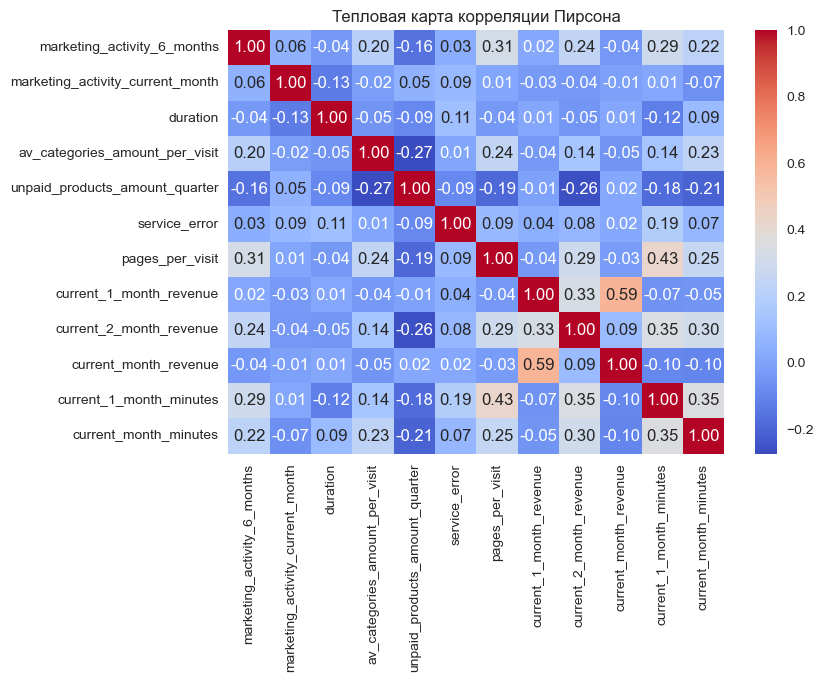

In [139]:
#Построим heatmap с корреляцией признаков
sns.heatmap(df_unify[numeric_coll].corr(), annot=True, cmap='coolwarm', fmt=".2f") 
plt.title('Тепловая карта корреляции Пирсона')

Существенной корреляции между признаками не наблюдается, однако, т.к. по ряду признаков мы ранее наблюдали выбивающиеся значения и ненормальное распределение, построим heatmap с корреляцией Спирмена 

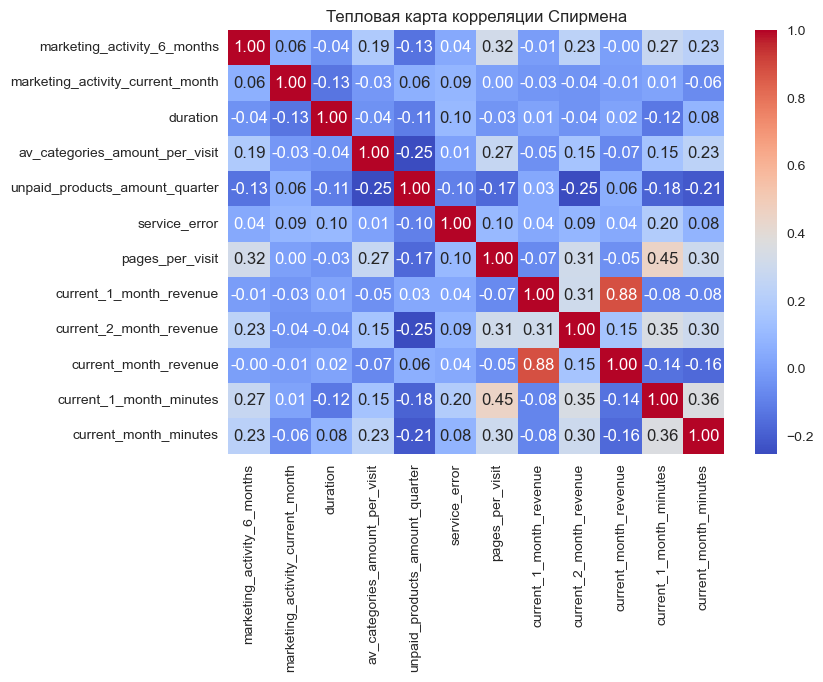

In [140]:
# Т.к. не по всем признакам наблюдается нормальное распределение построим heatmap с корреляцией Спирмена 
sns.heatmap(df_unify_numeric.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Спирмена')
plt.show()

Наблюдаем высокую положительную корреляцию Спирмана между признаками "выручка за текущий месяц" и "выручка за предыдущий месяц". Исходим из допущения что мультиколлинерность возникает при значениях  свыше 0,9, признаки не удаляем.

Построим матрицу корреляции Фи для оценки корреляции категориальных признаков

interval columns not set, guessing: ['id', 'marketing_activity_6_months', 'marketing_activity_current_month', 'duration', 'promotional_purchases', 'av_categories_amount_per_visit', 'unpaid_products_amount_quarter', 'service_error', 'pages_per_visit', 'current_1_month_revenue', 'current_2_month_revenue', 'current_month_revenue', 'current_1_month_minutes', 'current_month_minutes']


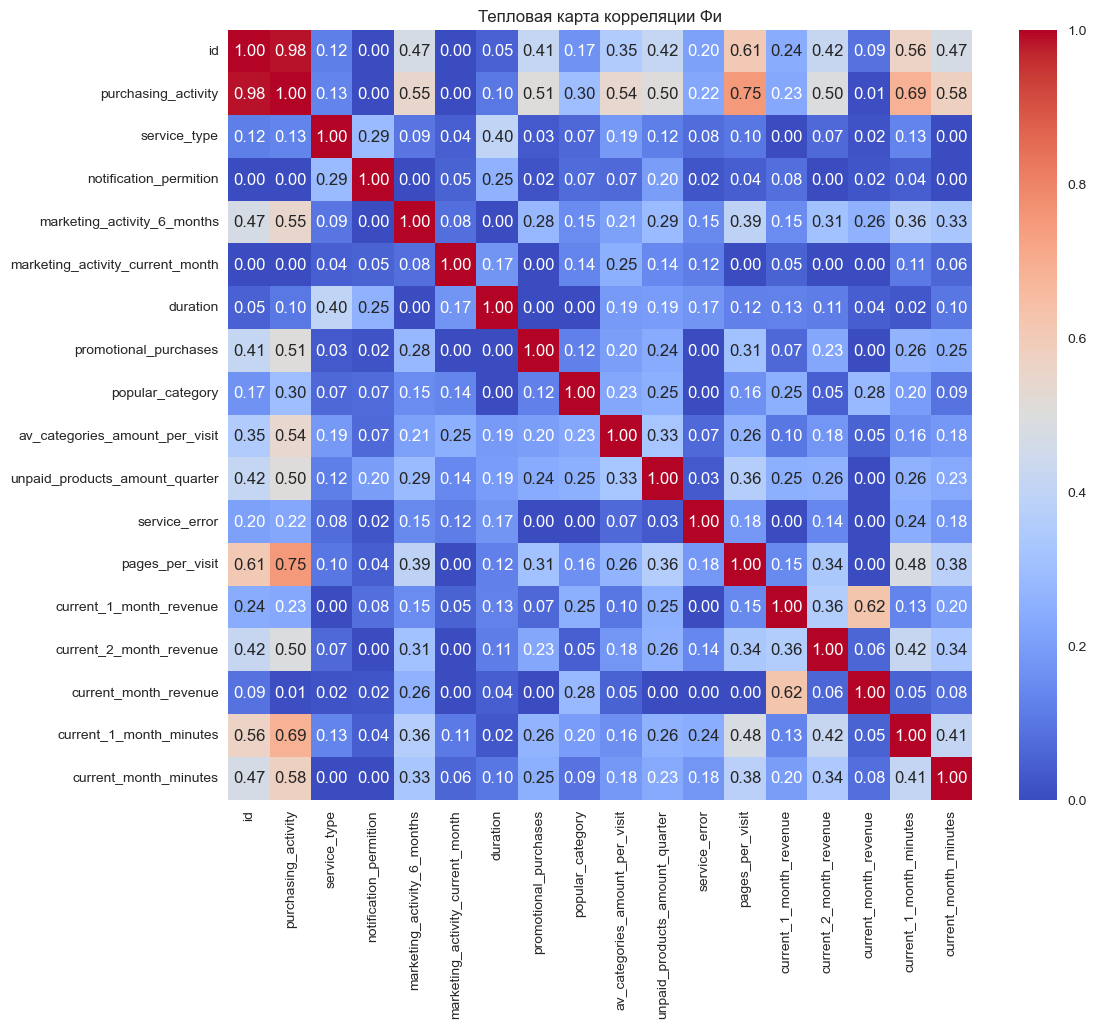

In [141]:
phik_matrix=df_unify.phik_matrix()
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции Фи')
plt.show()

1. Наблюдаем оч высокую корреляцию между целевой переменной и индексом (id). Очень похоже на утечку целевой переменной. В виду того, что индекс не будет использоваться как входящий признак в модели, игнорируем.
2. Наблюдаем высокую корреляцию между целевой переменной и средним количеством просмотренных страниц за визит (0,75).
3. Наблюдаем умененную корреляцию между целевой переменной и сл.признаками:
 - количество минут проведенных на сайте за предыдущий месяц (0,68)
 - количество минут проведенных на сайте за текущий месяц (0,58)
 - среднемесячное значение маркетинговых коммуникаций на последние 6 мес(0,55)
 - количество категорий товаров просмотренных на сайте за визит (0,54)
 - среднемесячная доля покупок по акции (0,5)
 - общее число неоплаченных товаров в корзине за последние 3 месяца (0,5)  

### Построение диаграмм рассеяния

Построение диаграмм рассеяния между целевым и входящими количественными признаками для поиска линейных зависимостей нецелесообразно, т.к. целевая переменная является качественным признаком с бинарными значениями.

### Итого по разделу:

1. Наблюдаем высокую положительную корреляцию Спирмана между признаками "выручка за текущий месяц" и "выручка за предыдущий месяц". Исходим из допущения, что мультиколлинерность возникает при значениях свыше 0,9, признаки не удаляем.
2. Наблюдаем оч высокую корреляцию между целевой переменной и индексом (id). Очень похоже на утечку целевой переменной. В виду того, что индекс не будет использоваться как входящий признак в модели, игнорируем.
3. Наблюдаем высокую корреляцию между целевой переменной и средним количеством просмотренных страниц за визит (0,75).
4. Наблюдаем умененную корреляцию между целевой переменной и сл.признаками:
 - количество минут проведенных на сайте за предыдущий месяц (0,68)
 - количество минут проведенных на сайте за текущий месяц (0,58)
 - среднемесячное значение маркетинговых коммуникаций на последние 6 мес(0,55)
 - количество категорий товаров просмотренных на сайте за визит (0,54)
 - среднемесячная доля покупок по акции (0,5)
 - общее число неоплаченных товаров в корзине за последние 3 месяца (0,5)  

## Построение пайплайна

**Подготовим данные к обучению:**
 - преобразуем целевой признак в числовой.  
 - уберем лишние признаки, с признаками утечки переменных (id)

In [142]:
df_unify.sample(5)

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes
393,215744,Снизилась,стандарт,да,1.7,5,439,0.31,Кухонная посуда,1,5,2,1,5421.5,4370.0,6016.9,6,9
635,215986,Прежний уровень,стандарт,да,4.9,4,203,0.11,Товары для детей,5,2,4,14,5296.0,5305.0,5433.8,17,10
320,215671,Снизилась,премиум,да,4.0,4,820,0.22,Косметика и аксесуары,1,4,8,6,5379.5,4670.0,6034.7,7,8
23,215374,Снизилась,стандарт,нет,2.9,5,268,0.98,Домашний текстиль,6,3,2,2,5762.5,4666.0,5720.9,11,8
761,216112,Прежний уровень,стандарт,да,4.6,3,179,0.21,Мелкая бытовая техника и электроника,5,1,4,4,5311.0,5428.0,5339.6,15,15


In [143]:
def y_to_binary(i): 
    if i=='Снизилась':
        return 1
    else:
        return 0

In [144]:
#Применим функцию для преобразования целевого признака в числовой
df_unify['purchasing_activity'] = df_unify['purchasing_activity'].apply(y_to_binary) 

In [145]:
df_unify.query('id==[215713, 216115]')

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes
362,215713,1,стандарт,да,4.6,5,293,0.24,Товары для детей,1,3,3,3,4821.0,4872.0,5221.4,12,14
764,216115,0,стандарт,нет,4.4,4,808,0.17,Мелкая бытовая техника и электроника,4,2,0,3,4802.5,4543.0,5157.4,11,9


In [146]:
df_unify_final = df_unify.drop('id',axis=1)
df_unify_final

,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes
0,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,0,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,0,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,0,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,0,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


In [147]:
#Обновим список категориальных и числовых признаков. 
ohe_columns=['service_type', 'popular_category','notification_permition']
num_columns=numeric_coll 


In [148]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    df_unify_final.drop('purchasing_activity', axis=1
    ),
    df_unify_final['purchasing_activity'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_unify_final['purchasing_activity']
)


In [149]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
)

In [150]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [151]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])

param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
 
        # словарь для модели SVC() устанавливаем доп параметр probability=True
        # это позволит достававать вероятности классов.
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'preprocessor__num':  [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
        
    },
    # словарь для модели KNeighborsClassifier() 
{
    'models': [KNeighborsClassifier()],
    'models__n_neighbors': range(2, 12),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
},

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [152]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_iter=100,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['service_type',
                                                                                'popular_category',
                                                                                'notification_permition']),
                                                                              ('num',
                                                                               Stan...
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 12),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [153]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['service_type',
                                                   'popular_category',
                                                   'notification_permition']),
                              

In [154]:
print('Метрика ROC-AUC для лучшей модели:\n', randomized_search.best_score_)

Метрика ROC-AUC для лучшей модели:
 0.9118324423597152


In [155]:
y_test_pred = randomized_search.predict(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8907879955063392


In [156]:
pd.DataFrame(randomized_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__n_neighbors,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023720,0.001047,0.012252,0.001708,RobustScaler(),2,3,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",0.741959,0.683667,0.775507,0.713119,0.718863,0.726623,0.030701,91
1,0.023491,0.002103,0.011625,0.000955,RobustScaler(),4,4,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': RobustScaler(), 'models_...",0.772057,0.883556,0.841385,0.856250,0.798198,0.830289,0.040138,47
2,0.020099,0.002470,0.012368,0.000482,StandardScaler(),3,4,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.803440,0.811500,0.823367,0.773986,0.771002,0.796659,0.020745,76
3,0.015514,0.001013,0.138704,0.004614,StandardScaler(),NaN,NaN,KNeighborsClassifier(),4,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.894684,0.885667,0.890541,0.894651,0.870890,0.887286,0.008843,26
4,0.016744,0.000398,0.010565,0.001196,MinMaxScaler(),3,5,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.822258,0.822833,0.843637,0.826464,0.806137,0.824266,0.011957,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.013802,0.000754,0.008085,0.000863,StandardScaler(),2,4,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.761727,0.773111,0.787838,0.807432,0.783784,0.782778,0.015304,81
96,0.018458,0.001261,0.008220,0.000739,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",NaN,3,"{'preprocessor__num': StandardScaler(), 'model...",0.882176,0.900222,0.924662,0.907545,0.864640,0.895849,0.020722,19
97,0.013389,0.000985,0.006875,0.000448,passthrough,4,5,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.744863,0.857944,0.860867,0.827872,0.823818,0.823073,0.041916,61
98,0.013140,0.000082,0.006398,0.001525,passthrough,5,5,DecisionTreeClassifier(random_state=42),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.812654,0.872167,0.873255,0.828604,0.837106,0.844757,0.024139,41


In [157]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.916907398491414


### Итого по разделу:
1. В качестве метрики оценки моделей выбрана ROC AUC, по сл. причинам:
 - нет точной информации о стоимости ошибки первого рода. Нет информации о стоимости мероприятий по удержанию клиента. Сложно оценить будут ли для бизнеса маркетинговые мероприятия в расчете на 1 клиента (FP) стоить дороже, чем потеря клиента.   
- Дисбаланс классов присутствует, но не является значительным, поэтому нет оснований считать что метрика ROC AUC будет излишне оптимистичной. 
2. В созданном пайплайне подготовки  и обучения моделей использованы 4 типа моделей, 4 метода кодирования данных, а  случайным поиском определены их комбинации и проведена проверка моделей на кроссвалидации и тестовых данных Метрика ROC-AUC на тестовой выборке: 0.92

## Анализ важности признаков. 

In [158]:
best_model = randomized_search.best_estimator_['models']
best_model

SVC(probability=True, random_state=42)

**Лучшей моделью (по метрике ROC_AUG) в пайплайне является svm. В пайплайне мы использовали ядро SVС по дефолту (не использовали kernel в качестве гипперпараметра), по умолчанию  SVS использует ядро rbf (не linear). Поэтому у нас нет доступа к весам коэффициентов для анализа влияния признаков и мы не можем использовать метод coefficients**  

Для решения этой задачи воспользуемся permutation_importance 

<Axes: ylabel='Feature'>

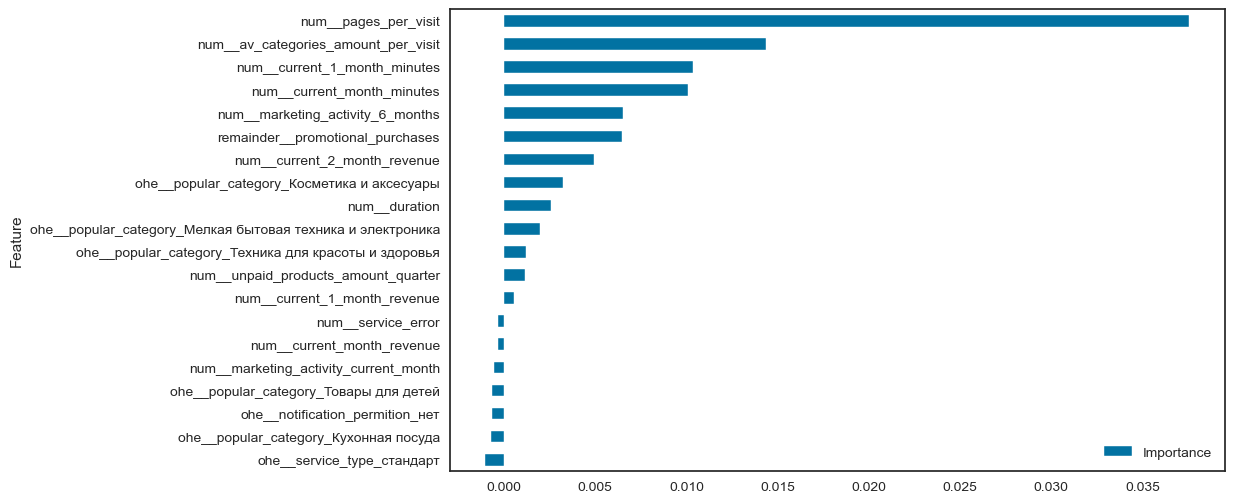

In [159]:
# Получаем лучший пайплайн из RandomizedSearchCV
best_pipeline = randomized_search.best_estimator_

# Подготавливаем тестовые данные через пайплайн, за исключением последнего шага (модели)
# Обращаемся к предпоследнему шагу пайплайна для преобразования значений признаков X_test'
preprocessor_pipeline = Pipeline(best_pipeline.steps[:-1])
X_test_preprocessed = preprocessor_pipeline.transform(X_test)

# Извлечем имена признаков 

features_names=preprocessor_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Вычисляем важность признаков (укажу количество повторений n_repeats=10 
# чтобы повысить надежность оценки)
result = permutation_importance(
    best_model, 
    X_test_preprocessed, 
    y_test, 
    scoring = 'roc_auc', 
    n_repeats=10, 
    random_state=42 
)


# Визуализируем важность признаков.

feature_importance = pd.DataFrame({'Feature': features_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Выводы по итогам анализа признаков лучшей модели SVC по метрике ROC_AUG:  
1. Наиболее важным признаком (с большим отрывом от остальным) является "среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца".
2. Также на предикт модели оказывают существенное влияние сл. 4 признака в порядке убывания:
 - Среднее количество категорий, которые покупатель просмотрел за визит в течение последнего месяца.
 - Количество минут, которые клиент провел на сайте в текущем месяце.
 - Количество минут, которые клиент провел на сайте в предыдущем месяце.
 - Количество минут, которые клиент провел на сайте в предпредыдущем месяце.

In [160]:
X_test_samples = shap.sample(X_test_preprocessed, 20) 
explainer = shap.KernelExplainer(best_model.predict, X_test_samples)

In [161]:
shap_values = explainer.shap_values(X_test_preprocessed, nsamples=100)

  0%|          | 0/325 [00:00<?, ?it/s]

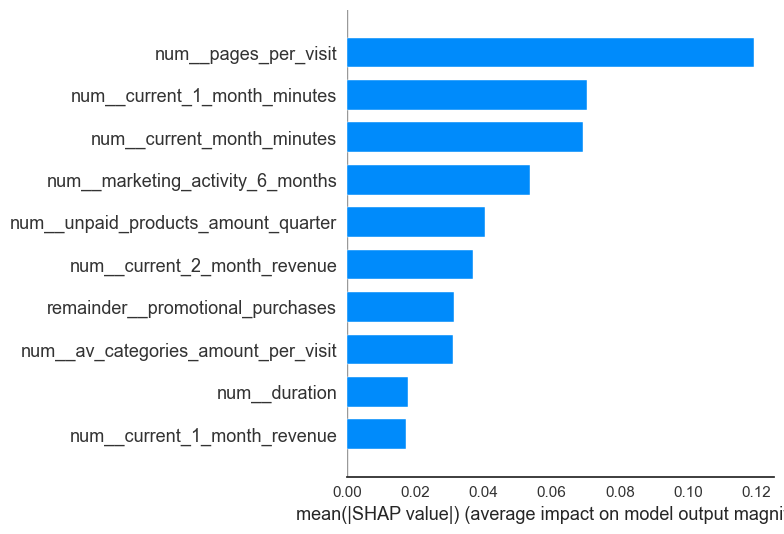

In [162]:
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=features_names, plot_type="bar", max_display=10)

По итогам анализа значимости признаков с использованием значений Шепли мы наблюдаем 2 и 3 признаки поменялись местами по влиянию на предикт модели, тройка лидеров не изменилась:
- Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
- Количество минут, которые клиент провел на сайте в текущем месяце.
- Количество минут, которые клиент провел на сайте в предыдущем месяце.

In [163]:
# Получаем ожидаемое (базовое) значение предсказания модели 
base_value = explainer.expected_value

# Создаем объект shap.Explanation
explainer_obj = shap.Explanation(values=shap_values,
                                 base_values=base_value,
                                 data=X_test_preprocessed,
                                 feature_names=features_names)

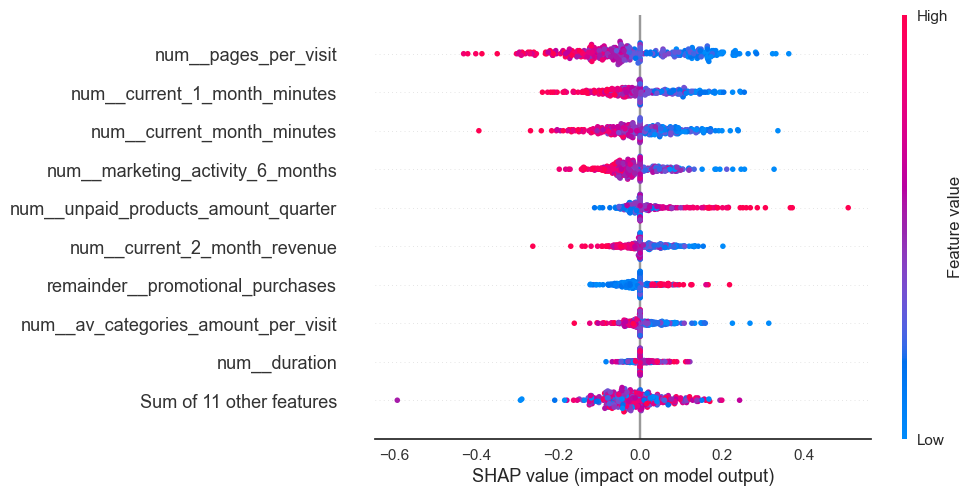

In [164]:
shap.plots.beeswarm(explainer_obj, max_display=10)

По итогам анализа графика beeswarm видим, что: 
 - чем выше значения 3х лидирующих признаков, тем ниже вероятность оттока (т.к. положительным классом у нас закодировано снижение покупательской активности)
 - высокая частотнось маркетинговых коммуникаций за последние 6 месяцев не оказывают большого влияния на итоговое решение модели, но низкие значения признака значительно повышают вероятность оттока (снижения покупательской активности).  Т.е маркетинговые коммуникации можно назвать "гигиеническим фактором". 

In [165]:
# для примера посмотрим оценку влияния признака для первого наблюдения.
explainer_obj[0]

.values =
array([-0.02648099, -0.0095319 , -0.00998234,  0.0067033 , -0.01348605,
        0.        ,  0.02579438, -0.04042827,  0.03769264,  0.00684464,
        0.07756015, -0.09163689, -0.02030691,  0.        ,  0.00041855,
       -0.05612899,  0.01206497, -0.05900447, -0.21608028,  0.02598846])

.base_values =
0.35000000000000003

.data =
array([ 1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.76923077,  1.        , -0.4440367 ,
       -1.        , -0.33333333, -1.33333333, -0.16666667, -0.33094714,
        0.69262295,  0.05522519,  0.32      ,  1.16666667,  0.91      ])

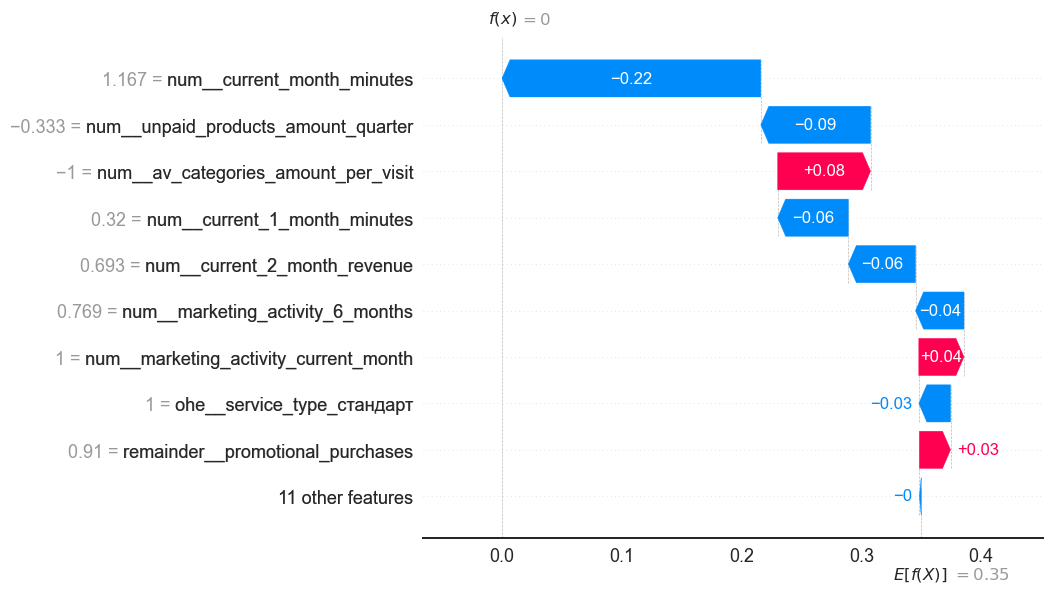

In [166]:
shap.plots.waterfall(explainer_obj[0])

В частности, на примере предикта по первому наблюдению тестовой выборки, видим прямое соответствие обобщающей оценке влияния 3х лидирующих признаков.

### Итого по разделу:
Выводы по итогам анализа признаков лучшей модели SVC по метрике ROC_AUG:
1. Наиболее важными признаками по итогам анализа permutation_importance и значений Шепли являются:
- Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
- Количество минут, которые клиент провел на сайте в текущем месяце.
- Количество минут, которые клиент провел на сайте в предыдущем месяце.

Влияние этих признаков также подтверждается коэффициентом корреляции Спирмана

2.  Чем выше значения 3х лидирующих признаков, тем ниже вероятность оттока (т.к. положительным классом у нас закодировано снижение покупательской активности). Рекомендация клиенту - стимулировать вовлечение пользователей на площадке (в первую очень по обозначенным в п.1 характеристикам поведения), анализировать эти характеристки при проведении А/В тест и маркетинговых активностей.


3. Высокая частотнось маркетинговых коммуникаций за последние 6 месяцев не оказывают большого влияния на итоговое решение модели, но низкие значения признака значительно повышают вероятность оттока (снижения покупательской активности).  Т.е маркетинговые коммуникации можно назвать "гигиеническим фактором". 

## Шаг 8. Сегментация покупателей

### Сегментация покупателей с использованием целевого признака "покупательская активность"

Из 4 сегментов покупателей предложенных в проекте:
1. Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.
2. Группа клиентов, которые покупают только технику, то есть товары с длинным жизненным циклом.
3. Группа клиентов, которые покупают товары из категории «Товары для себя» (новая категория, которую можно выделить на основе текущих) или «Товары для детей».
4. Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью

Снижение churn rate (оттока) среди наиболее прибыльных клиентов кажется приоритетной задачей поэтому рассмотрим 1й и 4й сегменты:
- гипотеза что 1й сегмент с минимальной прибылью, т.к. это акционщики. Если гипотеза подтвердиться, то пользователей этого сегмента не нужно удерживать и необходимо избегать доп трат на этих пользователей в рамках акций и коммуникаций.
- гипотеза что во втором (прибыльном) сегменте есть пользователи, склонные к оттоку и их можно удержать, увеличив интенсивность коммуникации.

In [167]:
probabilities = randomized_search.predict_proba(df_unify_final.drop('purchasing_activity', axis=1))
probabilities

array([[0.05293359, 0.94706641],
       [0.48445168, 0.51554832],
       [0.08434637, 0.91565363],
       ...,
       [0.95173547, 0.04826453],
       [0.88071006, 0.11928994],
       [0.87298208, 0.12701792]])

In [168]:
df_unify_final['positive_class_probability'] = pd.Series(probabilities[:, 1], index=df_unify_final.index)

In [169]:
df_unify_final['id']=df_unify['id']
df_unify_final.sample(1)

,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes,positive_class_probability,id
909,0,стандарт,нет,4.9,4,617,0.15,Товары для детей,3,2,6,7,3598.0,4493.0,4504.1,21,18,0.098665,216260


In [170]:
#Проверим что правильно "вернули" id на примере
df_unify.query('id==216162')

,id,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes
811,216162,0,премиум,да,5.5,4,631,0.26,Товары для детей,4,1,4,9,5259.5,5255.0,5385.6,13,18


In [171]:
# Добавим в основную таблицу df_unify данные о прибыли по пользователям из таблицы f_money.
df_unify_final=df_unify_final.merge(df_money, how='left', on='id')

In [172]:
check_df(df_unify_final)

Общая инфо:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   purchasing_activity               1297 non-null   int64  
 1   service_type                      1297 non-null   object 
 2   notification_permition            1297 non-null   object 
 3   marketing_activity_6_months       1297 non-null   float64
 4   marketing_activity_current_month  1297 non-null   int64  
 5   duration                          1297 non-null   int64  
 6   promotional_purchases             1297 non-null   float64
 7   popular_category                  1297 non-null   object 
 8   av_categories_amount_per_visit    1297 non-null   int64  
 9   unpaid_products_amount_quarter    1297 non-null   int64  
 10  service_error                     1297 non-null   int64  
 11  pages_per_visit                   1297 non-null   int64  

,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes,positive_class_probability,id,profit
0,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.947066,215349,4.16
1,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.515548,215350,3.13
2,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.915654,215351,4.87
3,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.974702,215352,4.21
4,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.807399,215353,3.95


**Выделим сегмент "Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности."**

In [173]:
df_unify_final.promotional_purchases.describe()

count    1297.000000
mean        0.320547
std         0.249657
min         0.110000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promotional_purchases, dtype: float64

In [174]:
# Отфильтруем все записи которые:
#- попали в 1 квартиль значений promotional_purchases
#- purchasing_activity = 0

In [175]:
segment_1=df_unify_final.query('promotional_purchases >= 0.3 & positive_class_probability > 0.7')
segment_1.sample(5)

,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes,positive_class_probability,id,profit
9,1,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6,0.705831,215360,4.55
201,1,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1,5678.5,4726.0,6194.6,12,11,0.983352,215552,4.33
32,1,стандарт,да,2.7,4,504,0.33,Техника для красоты и здоровья,2,4,2,4,5560.0,4729.0,5989.0,7,10,0.993289,215383,4.27
130,1,стандарт,да,3.8,3,844,0.93,Товары для детей,3,8,4,2,3720.0,4374.0,3560.1,10,11,0.995735,215481,4.42
321,1,стандарт,да,4.4,5,261,0.31,Кухонная посуда,1,6,1,2,4911.0,4128.0,4890.2,9,12,0.984562,215672,1.48


In [176]:
segment_1.shape

(256, 20)

In [177]:
print('Количество пользователей:', segment_1.shape[0])
print('Сегмент1 в % от предоставленной выборки:', segment_1.shape[0]/df_unify_final.shape[0]*100)

Количество пользователей: 256
Сегмент1 в % от предоставленной выборки: 19.737856592135696


In [178]:
segment_1.profit.describe()

count    256.000000
mean       3.962422
std        0.991699
min        1.060000
25%        3.257500
50%        4.010000
75%        4.600000
max        7.430000
Name: profit, dtype: float64

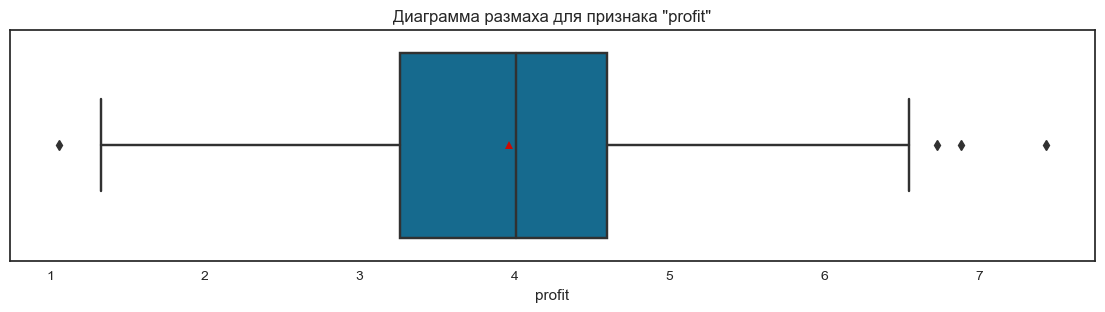

In [179]:
plot_boxplot(segment_1, 'profit')

In [180]:
interpret_boxplot(segment_1, 'profit')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'profit' - до 3.2575.
3. 50% значений 'profit' в диапазоне от 3.2575 до 4.6.
4. 25% значений 'profit' превышают 4.6.
5. Медиана 4.01
6. Среднее 3.96


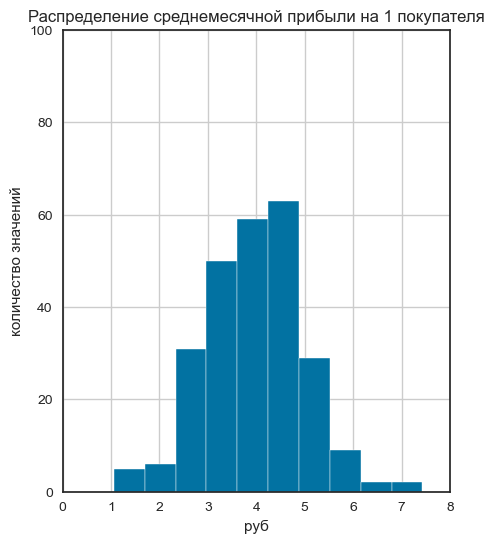

In [181]:
segment_1.plot(y='profit', kind='hist', grid=True, figsize=(5, 6),
bins=10, ylim=(0, 100), xlim=(0, 8), 
legend=False)
plt.title('Распределение среднемесячной прибыли на 1 покупателя')
plt.ylabel('количество значений')
plt.xlabel('руб')
plt.show()

**Вывод: Несмотря на то, что показатели моды, медианы и ср значение немного ниже чем в основной выборке гипотеза о том, что это сегмент с минимальной прибылью /отсутствием прибыли на пользователя не оправдалась, с сегментом можно работать на удержание, но не в первом приоритете.**

Выделим приоритетный сегмент:
- более прибыльные клиенты (ТОП 25 %)
- со значением признака Покупательская активность "снизилась". 

В качестве пороговых значений сегментации используем:
- ТОП 25 по profit (4,67) 
- значения = 0 для purchasing_activity

In [182]:
df_unify_final.marketing_activity_6_months.describe()

count    1297.000000
mean        4.254433
std         1.015618
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: marketing_activity_6_months, dtype: float64

In [183]:
df_prior_segment = df_unify_final.query('profit > 4.67 & positive_class_probability >=0.7')
df_prior_segment.sample(5)

,purchasing_activity,service_type,notification_permition,marketing_activity_6_months,marketing_activity_current_month,duration,promotional_purchases,popular_category,av_categories_amount_per_visit,unpaid_products_amount_quarter,service_error,pages_per_visit,current_1_month_revenue,current_2_month_revenue,current_month_revenue,current_1_month_minutes,current_month_minutes,positive_class_probability,id,profit
300,1,стандарт,нет,2.4,3,715,0.40,Кухонная посуда,3,5,5,5,5109.5,4217.0,5498.2,10,8,0.991912,215651,5.15
292,1,премиум,да,4.8,4,672,0.39,Товары для детей,1,5,4,6,6227.0,4931.0,6267.3,7,10,0.985593,215643,5.59
346,1,премиум,да,3.9,4,935,0.39,Техника для красоты и здоровья,3,2,6,4,3688.0,4660.0,3993.5,7,10,0.887990,215697,5.02
231,1,стандарт,да,4.0,3,763,0.35,Товары для детей,3,3,2,3,4180.0,4688.0,4414.0,12,13,0.899991,215582,5.06
287,1,стандарт,да,2.4,4,549,0.30,Кухонная посуда,1,6,3,2,5195.0,4436.0,4924.6,14,12,0.992752,215638,4.94


In [184]:
print('Количество пользователей:', df_prior_segment.shape[0])
print('Приоритетный сегмент в % от предоставленной выборки:', df_prior_segment.shape[0]/df_unify.shape[0]*100)

Количество пользователей: 90
Приоритетный сегмент в % от предоставленной выборки: 6.939090208172706


Сегмент получился достаточно большим для проведения стат анализа. На мой взгляд целесообразно начать анализ именно с этого сегмента

### Формирование предложений по повышению покупательской активности

Проведем анализ значений 3х наиболее значимых признаков:

In [185]:
df_prior_segment.av_categories_amount_per_visit.describe()

count    90.000000
mean      2.344444
std       1.133366
min       1.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       6.000000
Name: av_categories_amount_per_visit, dtype: float64

In [186]:
interpret_boxplot(df_prior_segment, 'av_categories_amount_per_visit')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'av_categories_amount_per_visit' - до 2.0.
3. 50% значений 'av_categories_amount_per_visit' в диапазоне от 2.0 до 3.0.
4. 25% значений 'av_categories_amount_per_visit' превышают 3.0.
5. Медиана 2.0
6. Среднее 2.34


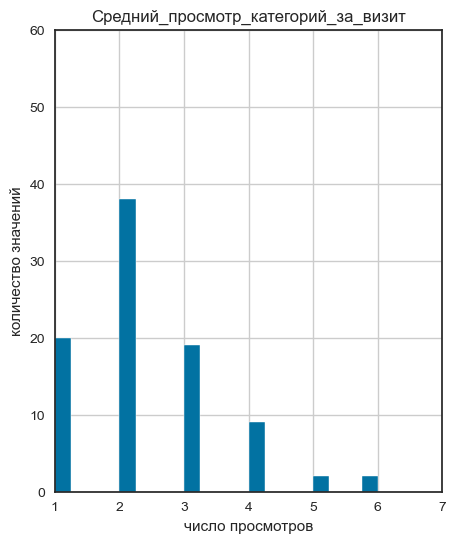

In [187]:
df_prior_segment.plot(y='av_categories_amount_per_visit', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 60), xlim=(1, 7), 
legend=False)
plt.title('Средний_просмотр_категорий_за_визит')
plt.ylabel('количество значений')
plt.xlabel('число просмотров')
plt.show()

По итогам стат анализа признака "Среднее количество просмотренных категорий за визит":
 - медиана (первоначальная выборка 3, приоритетная категория 2),
 - среднее (3.2, 2.3)
 - мода(3, 2) 
 что указывает на меньшую заинтересованность пользователей приоритетного сегмента в продукции площадки, чем у пользователей первоначальной выборки.
 Возможное решение - разработка /оптимизация рекомендаций по товарам, заинтересовавших эту группу пользователей. Для тех пользователей приоритетного сегмента которые не дали согласие на отправление им рекомендаций - рекомендация может происходить в момент добавления товаров в корзину (как правило пользователь уже аутентифицирован)  

In [188]:
df_prior_segment['current_month_minutes'].describe()

count    90.000000
mean     10.011111
std       2.410158
min       5.000000
25%       9.000000
50%      10.000000
75%      12.000000
max      19.000000
Name: current_month_minutes, dtype: float64

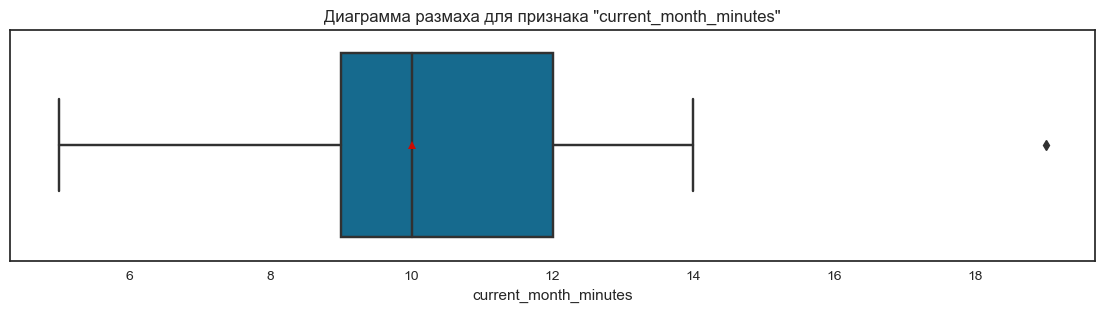

In [189]:
plot_boxplot(df_prior_segment, 'current_month_minutes')

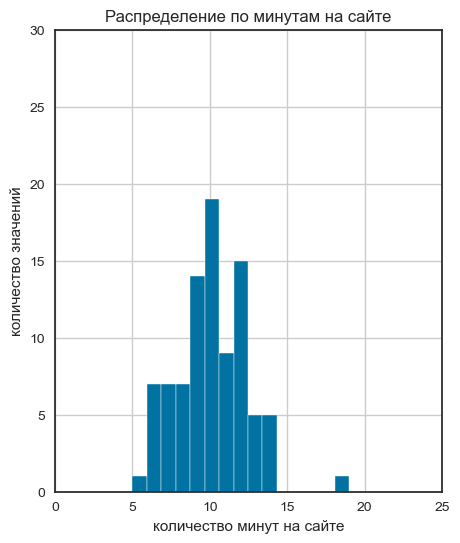

In [190]:
df_prior_segment.plot(y='current_month_minutes', kind='hist', grid=True, figsize=(5, 6),
bins=15, ylim=(0, 30), xlim=(0, 25), 
legend=False)
plt.title('Распределение по минутам на сайте')
plt.ylabel('количество значений')
plt.xlabel('количество минут на сайте')
plt.show()

По итогам стат анализа признака "Количество минут проведенных на сайте за текущий месяц":
 - медиана (первоначальная выборка 13, приоритетная категория 10),
 - среднее (13.3, 10.1)
 - мода(15, 10) 
 что указывает на меньшую заинтересованность пользователей приоритетного сегмента в контенте площадки, чем у пользователей первоначальной выборки.

In [191]:
df_prior_segment['current_1_month_minutes'].describe()

count    90.000000
mean      9.666667
std       2.146332
min       5.000000
25%       8.000000
50%      10.000000
75%      11.000000
max      14.000000
Name: current_1_month_minutes, dtype: float64

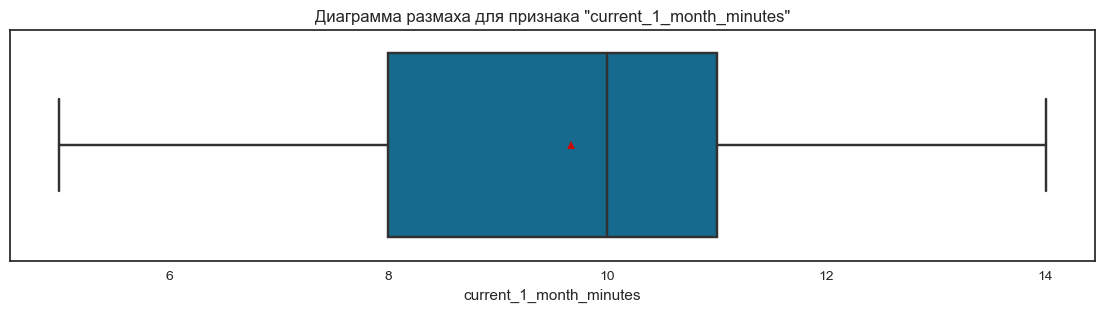

In [192]:
plot_boxplot(df_prior_segment, 'current_1_month_minutes')

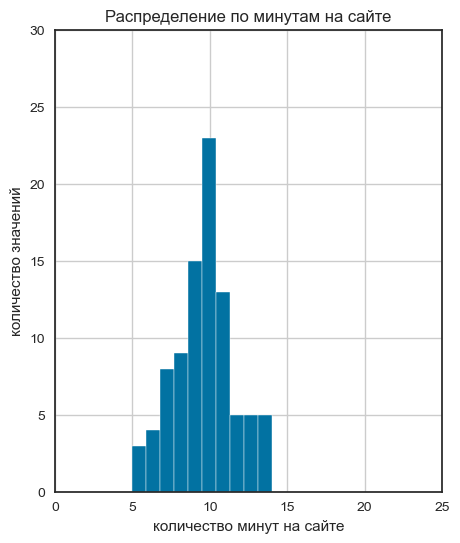

In [193]:
df_prior_segment.plot(y='current_1_month_minutes', kind='hist', grid=True, figsize=(5, 6),
bins=10, ylim=(0, 30), xlim=(0, 25), 
legend=False)
plt.title('Распределение по минутам на сайте')
plt.ylabel('количество значений')
plt.xlabel('количество минут на сайте')
plt.show()

По итогам стат анализа признака "Количество минут проведенных на сайте за предыдущий месяц":
 - медиана (первоначальная выборка 13, приоритетная категория 10),
 - среднее (13.3, 9,6)
 - мода (15, 10) 
 что указывает на меньшую заинтересованность пользователей приоритетного сегмента в контенте площадки уже 2 месяца подряд, чем у пользователей первоначальной выборки. 


In [194]:
df_prior_segment['marketing_activity_6_months'].describe()

count    90.000000
mean      3.491111
std       0.993535
min       0.900000
25%       3.000000
50%       3.600000
75%       4.100000
max       5.600000
Name: marketing_activity_6_months, dtype: float64

In [195]:
interpret_boxplot(df_prior_segment, 'marketing_activity_6_months')

Статистический анализ признака:
1. Значений выходящих за доверительные интервалы есть.
2. 25% значений 'marketing_activity_6_months' - до 3.0.
3. 50% значений 'marketing_activity_6_months' в диапазоне от 3.0 до 4.1.
4. 25% значений 'marketing_activity_6_months' превышают 4.1.
5. Медиана 3.6
6. Среднее 3.49


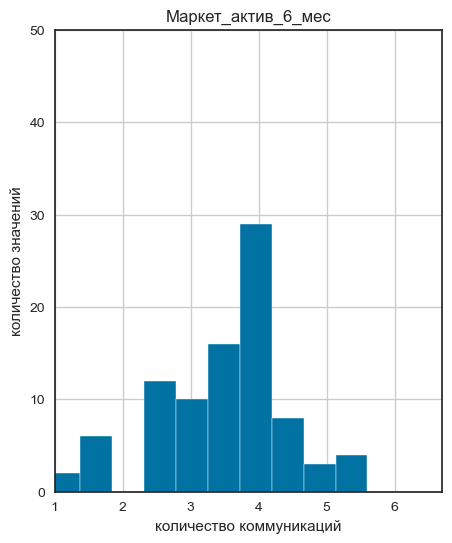

In [196]:
df_prior_segment.plot(y='marketing_activity_6_months', kind='hist', grid=True, figsize=(5, 6),
bins=10, ylim=(0, 50), xlim=(1, 6.7), 
legend=False)
plt.title('Маркет_актив_6_мес')
plt.ylabel('количество значений')
plt.xlabel('количество коммуникаций')
plt.show()

По итогам стат анализа признака "Маркетинговые коммуникации за 6 месяцев":
 - медиана (первоначальная выборка 4.2 приоритетная категория 3,6),
 - среднее (4.25, 3.49)
 - мода совпадает
 - 50% значений  в диапазоне от 3.0 до 4.1. В первоначальной выборке от 3.7 до 4.9.
 что указывает на возможность и целесообразность проведения дополнительных коммуникаций с приоритетным сегментом.

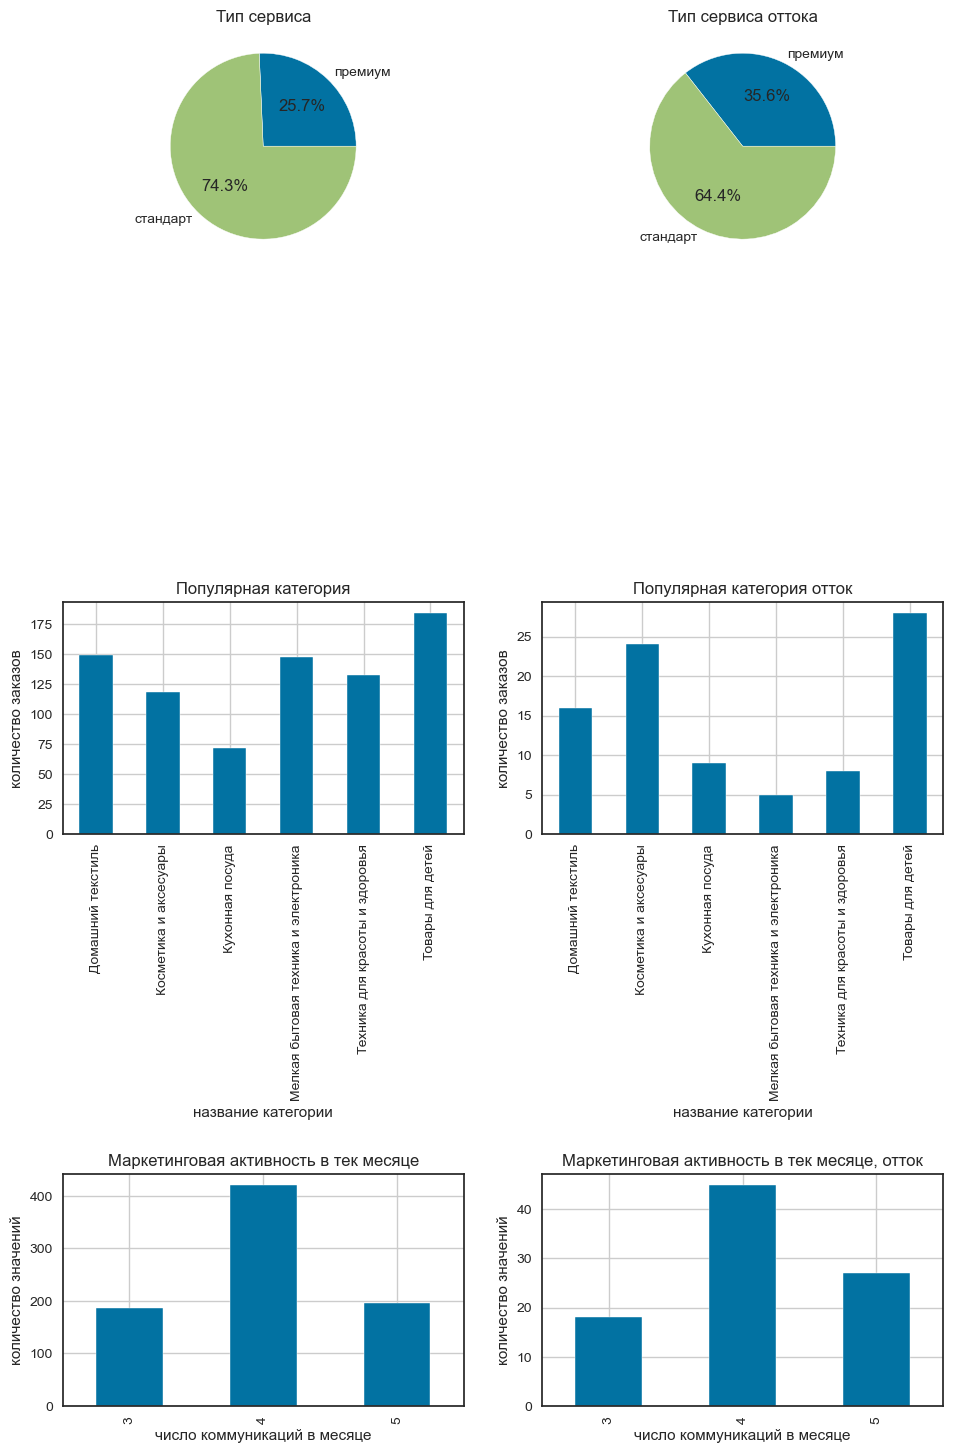

In [197]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))

# График "Тип сервиса"
df_market_file_active_users.pivot_table(index='service_type', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[0, 0])
ax[0, 0].set_title('Тип сервиса')
ax[0, 0].set_ylabel('')
ax[0, 0].set_xlabel('')

# График "Тип сервиса"
df_prior_segment.pivot_table(index='service_type', values='id', aggfunc='count').plot(kind='pie', y='id', grid=True, legend=False, autopct='%1.1f%%', ax=ax[0, 1])
ax[0, 1].set_title('Тип сервиса оттока')
ax[0, 1].set_ylabel('')
ax[0, 1].set_xlabel('')

# График "Популярная категория"
df_market_file_active_users.pivot_table(index='popular_category', values='id', aggfunc='count').plot(kind='bar', grid=True, legend=False, ax=ax[1, 0])
ax[1, 0].set_title('Популярная категория')
ax[1, 0].set_ylabel('количество заказов')
ax[1, 0].set_xlabel('название категории')

# График "Популярная категория"
df_prior_segment.pivot_table(index='popular_category', values='id', aggfunc='count').plot(kind='bar', grid=True, legend=False, ax=ax[1, 1])
ax[1, 1].set_title('Популярная категория отток')
ax[1, 1].set_ylabel('количество заказов')
ax[1, 1].set_xlabel('название категории')

(df_market_file_active_users.pivot_table(
    index='marketing_activity_current_month',
    values='id', 
    aggfunc='count'
).plot(kind='bar', grid=True, legend=False, ax=ax[2, 0]))
ax[2, 0].set_title('Маркетинговая активность в тек месяце')
ax[2, 0].set_ylabel('количество значений')
ax[2, 0].set_xlabel('число коммуникаций в месяце')

(df_prior_segment.pivot_table(
    index='marketing_activity_current_month',
    values='id', 
    aggfunc='count'
).plot(kind='bar', grid=True, legend=False, ax=ax[2, 1]))
ax[2, 1].set_title('Маркетинговая активность в тек месяце, отток')
ax[2, 1].set_ylabel('количество значений')
ax[2, 1].set_xlabel('число коммуникаций в месяце')

plt.tight_layout(pad=2.0) 
plt.show()

Наблюдаем ранее выявленный факт - доля категорий с техникой у пользователей склонных к оттоку значительно ниже, чем у активных пользователей.
Возможное решение сосредоточится именно на этом подсегменте пользователей, постепено мотивируя их к покупке товаров с долгим жизненным циклом.

In [198]:
df_prior_segment['promotional_purchases'].describe()

count    90.000000
mean      0.428444
std       0.276055
min       0.120000
25%       0.240000
50%       0.320000
75%       0.400000
max       0.990000
Name: promotional_purchases, dtype: float64

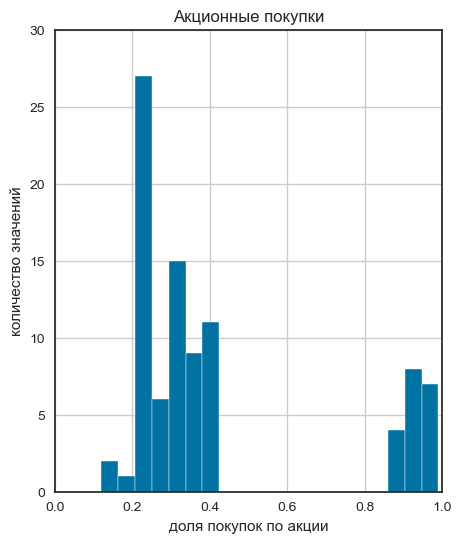

In [199]:
df_prior_segment.plot(y='promotional_purchases', kind='hist', grid=True, figsize=(5, 6),
bins=20, ylim=(0, 30), xlim=(0, 1), 
legend=False)
plt.title('Акционные покупки')
plt.ylabel('количество значений')
plt.xlabel('доля покупок по акции')
plt.show()

Наблюдаем ранее выявленный факт - доля ационных покупок у приоритетного сегмента выше, чем у первоначальной выборки, что является одной из характеристик клиентов склонных к оттоку. 
Возможное решение - сократь установить доп лимит на покупу товаров по акции в шт. выше 0,5 от общего числа покупок.

### Итого выводы по разделу:

1. В качестве приоритетного сегмента для анализа выделен сегмент:
- более прибыльные клиенты (ТОП 25 %)
- со значением признака Покупательская активность "снизилась".

Это позволит в первую очередь сконцентрироваться на срочном (готовы уйти) и важном (наиболее прибыльные клиенты). 

2. По итогам анализа значений значимых признаков для приоритетного сегмента можно сформулировать сл. предложения:
- Разработка /оптимизация рекомендаций по товарам, заинтересовавших эту группу пользователей. Для тех пользователей приоритетного сегмента, которые не дали согласие на отправление им рекомендаций - рекомендацию целесообразно проводить в момент добавления товаров в корзину (как правило, пользователь уже аутентифицирован).  Это позволить поднять важные для недопущения оттока метрики  "Количество минут проведенных на сайте", "Среднее количество просмотренных категорий за визит"
- Проведение дополнительных коммуникаций c выделенным сегментом(там где возможно) рассылки, звонки, показы рекламы до уровня 3.7 - 4.9 контактов в месяц.
- Доля категорий с техникой у пользователей склонных к оттоку значительно ниже, чем у активных пользователей. Возможное решение сосредоточится именно на этом подсегменте пользователей, постепено мотивируя их к покупке товаров с долгим жизненным циклом.
- Доля ационных покупок у приоритетного сегмента выше, чем у первоначальной выборки, что является одной из характеристик клиентов склонных к оттоку. Возможное решение - сократь установить доп лимит на покупу товаров по акции в шт. выше 0,5 от общего числа покупок.
 

## Общий вывод

Итого:
1.Загружены и изучены данные.

2. Данные предобработаны, приведены в соответствующие форматы. Найдены и удалены неявные дубликаты. Типы данных приведены в соответствие.

3 Проведен  исследовательский анализ категориальных и количественных признаков всех 4 таблиц.

4. Проведено объединение таблиц по уникальному ключу id пользователя и созданием доп. признаков. 

5. Проведен корреляционный анализ. Выявили:
    - высокую положительную корреляцию Спирмана между признаками "выручка за текущий месяц" и "выручка за предыдущий месяц". Исходим из допущения, что мультиколлинерность возникает при значениях свыше 0,9, признаки не удаляем.
    - оч высокую корреляцию между целевой переменной и индексом (id). Очень похоже на утечку целевой переменной. В виду того, что индекс не будет использоваться как входящий признак в модели, игнорируем.
    - высокую корреляцию между целевой переменной и средним количеством просмотренных страниц за визит (0,75).
    - умененную корреляцию между целевой переменной и сл.признаками: количество минут проведенных на сайте за предыдущий месяц (0,68)
количество минут проведенных на сайте за текущий месяц (0,58), среднемесячное значение маркетинговых коммуникаций на последние 6 мес(0,55)
количество категорий товаров просмотренных на сайте за визит (0,54), среднемесячная доля покупок по акции (0,5), общее число неоплаченных товаров в корзине за последние 3 месяца (0,5)

6. Построен пайплайн.
    6.1. В качестве метрики оценки моделей выбрана ROC AUC, по сл. причинам:
нет точной информации о стоимости ошибки первого рода. Нет информации о стоимости мероприятий по удержанию клиента. Сложно оценить будут ли для бизнеса маркетинговые мероприятия в расчете на 1 клиента (FP) стоить дороже, чем потеря клиента.
Дисбаланс классов присутствует, но не является значительным, поэтому нет оснований считать что метрика ROC AUC будет излишне оптимистичной.
    6.2. В созданном пайплайне подготовки и обучения моделей использованы 4 типа моделей, 4 метода кодирования данных, случайным поиском перебирались в т.ч. гипперпараметры моделей, определены их комбинации, проведена проверка моделей на тестовой выборке, определа лучшая модель.

7. Проверен анализ важности признаков:
    7.1. Наиболее важными признаками по итогам анализа permutation_importance и значений Шепли являются:
    - Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
    - Количество минут, которые клиент провел на сайте в текущем месяце.
    - Количество минут, которые клиент провел на сайте в предыдущем месяце.

    Влияние этих признаков также подтверждается коэффициентом Фи

    7.2.  Чем выше значения 3х лидирующих признаков, тем ниже вероятность оттока (т.к. положительным классом у нас закодировано снижение покупательской активности). Рекомендация клиенту - стимулировать вовлечение пользователей на площадке (в первую очень по обозначенным в п.1 характеристикам поведения), анализировать эти характеристки при проведении А/В тест и маркетинговых активностей.


    7.3. Высокая частотнось маркетинговых коммуникаций за последние 6 месяцев не оказывают большого влияния на итоговое решение модели, но низкие значения признака значительно повышают вероятность оттока (снижения покупательской активности).  Т.е маркетинговые коммуникации можно назвать "гигиеническим фактором". 
    
8. Проведена сегментация покупателей и сформированы рекомендации для заказчика по работе с выделенным сегментом.

    8.1 В качестве приоритетного сегмента для анализа выделен сегмент:
    - более прибыльные клиенты (ТОП 25 %)
    - со значением признака Покупательская активность "снизилась".
Это позволит в первую очередь сконцентрироваться на срочном (готовы уйти) и важном (наиболее прибыльные клиенты).

    8.2 По итогам анализа значений значимых признаков для приоритетного сегмента можно сформулировать сл. предложения:
- Разработка /оптимизация рекомендаций по товарам, заинтересовавших эту группу пользователей. Для тех пользователей приоритетного сегмента, которые не дали согласие на отправление им рекомендаций - рекомендацию целесообразно проводить в момент добавления товаров в корзину (как правило, пользователь уже аутентифицирован).  Это позволить поднять важные для недопущения оттока метрики  "Количество минут проведенных на сайте", "Среднее количество просмотренных категорий за визит"
- Проведение дополнительных коммуникаций c выделенным сегментом(там где возможно) рассылки, звонки, показы рекламы до уровня 3.7 - 4.9 контактов в месяц.
- Доля категорий с техникой у пользователей склонных к оттоку значительно ниже, чем у активных пользователей. Возможное решение сосредоточится именно на этом подсегменте пользователей, постепено мотивируя их к покупке товаров с долгим жизненным циклом.
- Доля ационных покупок у приоритетного сегмента выше, чем у первоначальной выборки, что является одной из характеристик клиентов склонных к оттоку. Возможное решение - сократь установить доп лимит на покупу товаров по акции в шт. выше 0,5 от общего числа покупок. 
    

## Сырой контент

import imblearn
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },